In [1]:
import datetime

import colormaps
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import xarray as xr
from jetutils.anyspell import get_persistent_jet_spells, mask_from_spells_pl, subset_around_onset, get_persistent_spell_times_from_som, get_spells
from jetutils.clustering import Experiment, RAW_REALSPACE, labels_to_centers
from jetutils.data import DataHandler, open_da
from jetutils.definitions import (
    DATADIR,
    FIGURES,
    PRETTIER_VARNAME,
    YEARS,
    compute,
    get_region,
    infer_direction,
    polars_to_xarray,
    xarray_to_polars,
    labels_to_mask,
)
from jetutils.jet_finding import JetFindingExperiment
from jetutils.plots import COLORS, COLORS_EXT, Clusterplot, gather_normal_da_jets_wrapper, _gather_normal_da_jets_wrapper
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

%load_ext autoreload
%autoreload 2
%matplotlib inline

Found config override file at  /storage/homefs/hb22g102/.jetutils.ini
Guessed N_WORKERS :  1
Guessed MEMORY_LIMIT :  153600


In [2]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/1"))
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
jet_pos_da = exp.jet_position_as_da()
# props_as_df = get_double_jet_index(props_as_df, jet_pos_da)
exp_s = Experiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/2"))

da_s = exp_s.da
da_s = da_s.sel(time=da_s.time.dt.hour == 0)

ds_ = ds.sel(time=ds.time.dt.hour == 0)
ds_ = ds_.sel(time=ds_.time.dt.season == "JJA")

# Define all jet spells once

In [3]:
spells_from_jet_daily_stj_cs = get_persistent_jet_spells(
    props_as_df,
    "com_speed",
    "STJ",
    "JJA",
    q=0.6,
    daily=True,
    minlen=datetime.timedelta(days=6),
    fill_holes=datetime.timedelta(hours=12),
)
spells_from_jet_daily_edj_cs = get_persistent_jet_spells(
    props_as_df,
    "com_speed",
    "EDJ",
    "JJA",
    q=0.67,
    daily=True,
    minlen=datetime.timedelta(days=6),
    fill_holes=datetime.timedelta(hours=12),
)
spells_from_jet_daily_stj_pe = get_persistent_jet_spells(
    props_as_df,
    "persistence",
    "STJ",
    "JJA",
    q=0.6,
    daily=True,
    minlen=datetime.timedelta(days=9),
    fill_holes=datetime.timedelta(hours=0),
)
spells_from_jet_daily_edj_pe = get_persistent_jet_spells(
    props_as_df,
    "persistence",
    "EDJ",
    "JJA",
    q=0.6,
    daily=True,
    minlen=datetime.timedelta(days=8),
    fill_holes=datetime.timedelta(hours=0),
)
spells_list = {
    "STJ com spe": spells_from_jet_daily_stj_cs,
    "EDJ com spe": spells_from_jet_daily_edj_cs,
    "STJ lifetime": spells_from_jet_daily_stj_pe,
    "EDJ lifetime": spells_from_jet_daily_edj_pe,
}

spells_from_jet_daily_stj_cs = get_persistent_jet_spells(
    props_as_df,
    "com_speed",
    "STJ",
    "JJA",
    q=0.6,
    daily=True,
    minlen=datetime.timedelta(days=6),
    fill_holes=datetime.timedelta(hours=12),
    time_before=datetime.timedelta(days=4),
)
spells_from_jet_daily_edj_cs = get_persistent_jet_spells(
    props_as_df,
    "com_speed",
    "EDJ",
    "JJA",
    q=0.67,
    daily=True,
    minlen=datetime.timedelta(days=6),
    fill_holes=datetime.timedelta(hours=12),
    time_before=datetime.timedelta(days=4),
)
spells_from_jet_daily_stj_pe = get_persistent_jet_spells(
    props_as_df,
    "persistence",
    "STJ",
    "JJA",
    q=0.6,
    daily=True,
    minlen=datetime.timedelta(days=9),
    fill_holes=datetime.timedelta(hours=0),
    time_before=datetime.timedelta(days=4),
)
spells_from_jet_daily_edj_pe = get_persistent_jet_spells(
    props_as_df,
    "persistence",
    "EDJ",
    "JJA",
    q=0.6,
    daily=True,
    minlen=datetime.timedelta(days=8),
    fill_holes=datetime.timedelta(hours=0),
    time_before=datetime.timedelta(days=4),
)
spells_list_time_before = {
    "STJ com spe": spells_from_jet_daily_stj_cs,
    "EDJ com spe": spells_from_jet_daily_edj_cs,
    "STJ lifetime": spells_from_jet_daily_stj_pe,
    "EDJ lifetime": spells_from_jet_daily_edj_pe,
}

# compare with SOM hotspells

In [4]:
metric = "euclidean"
nx = 6
ny = 4
exp_s = Experiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/2"))

ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    activation_distance=metric,
    return_type=RAW_REALSPACE,
    force=False,
    sigma=2,
    train_kwargs=dict(num_epochs=20),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
if not ds_center_path.is_file():
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

from sklearn.metrics import pairwise_distances

dists = pairwise_distances(net.weights)
sigma = np.quantile(dists[dists > 0].flatten(), 0.05)
spells_from_som = get_persistent_spell_times_from_som(
    labels, dists, sigma, 47, nt_before=20, nojune=True, daily=True
)
spells_list["SOM"] = spells_from_som

In [5]:
da = ds["s"].sel(time=ds.time.dt.season=="JJA").chunk("auto")
speed_realspace = ((da.data[1:] - da.data[:-1])  ** 2).sum(axis=(1, 2))
speed_realspace = compute(speed_realspace, progress_flag=True)
speed_realspace = pl.DataFrame({"time": da.time.values[1:], "speed": speed_realspace})
spells_list["abs"] = get_spells(speed_realspace, "speed", q=0.94)

[########################################] | 100% Completed | 10.71 s


In [9]:
file_errors_location = f'{DATADIR}/ERA5/heatwaves_duncan.xlsx'
df = pl.read_excel(file_errors_location)
for i in range(1, 7):
    dates = f"dates{i}"
    duration = f"duration{i}"
    df_ = df[[duration, dates]].filter(pl.col(duration) > 3)
    df_ = df_.with_columns(
        start=pl.col(dates).str.split("/").list.get(0).str.strptime(pl.Datetime), 
        end=pl.col(dates).str.split("/").list.get(1).str.strptime(pl.Datetime)
    )
    df_ = df_.with_columns(time=pl.date_ranges(pl.col("start"), pl.col("end")))
    df_ = df_.drop(dates, duration, "start", "end")
    df_ = df_.with_row_index(name="spell").explode("time")
    spells_list[f"region {i}"] = df_

22
23
22
23
22
21
36
48
53
63
44
46


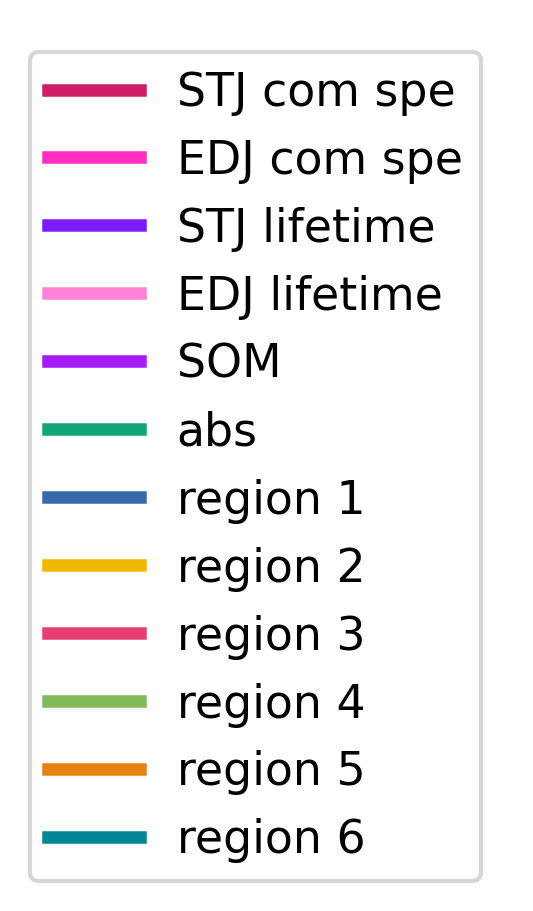

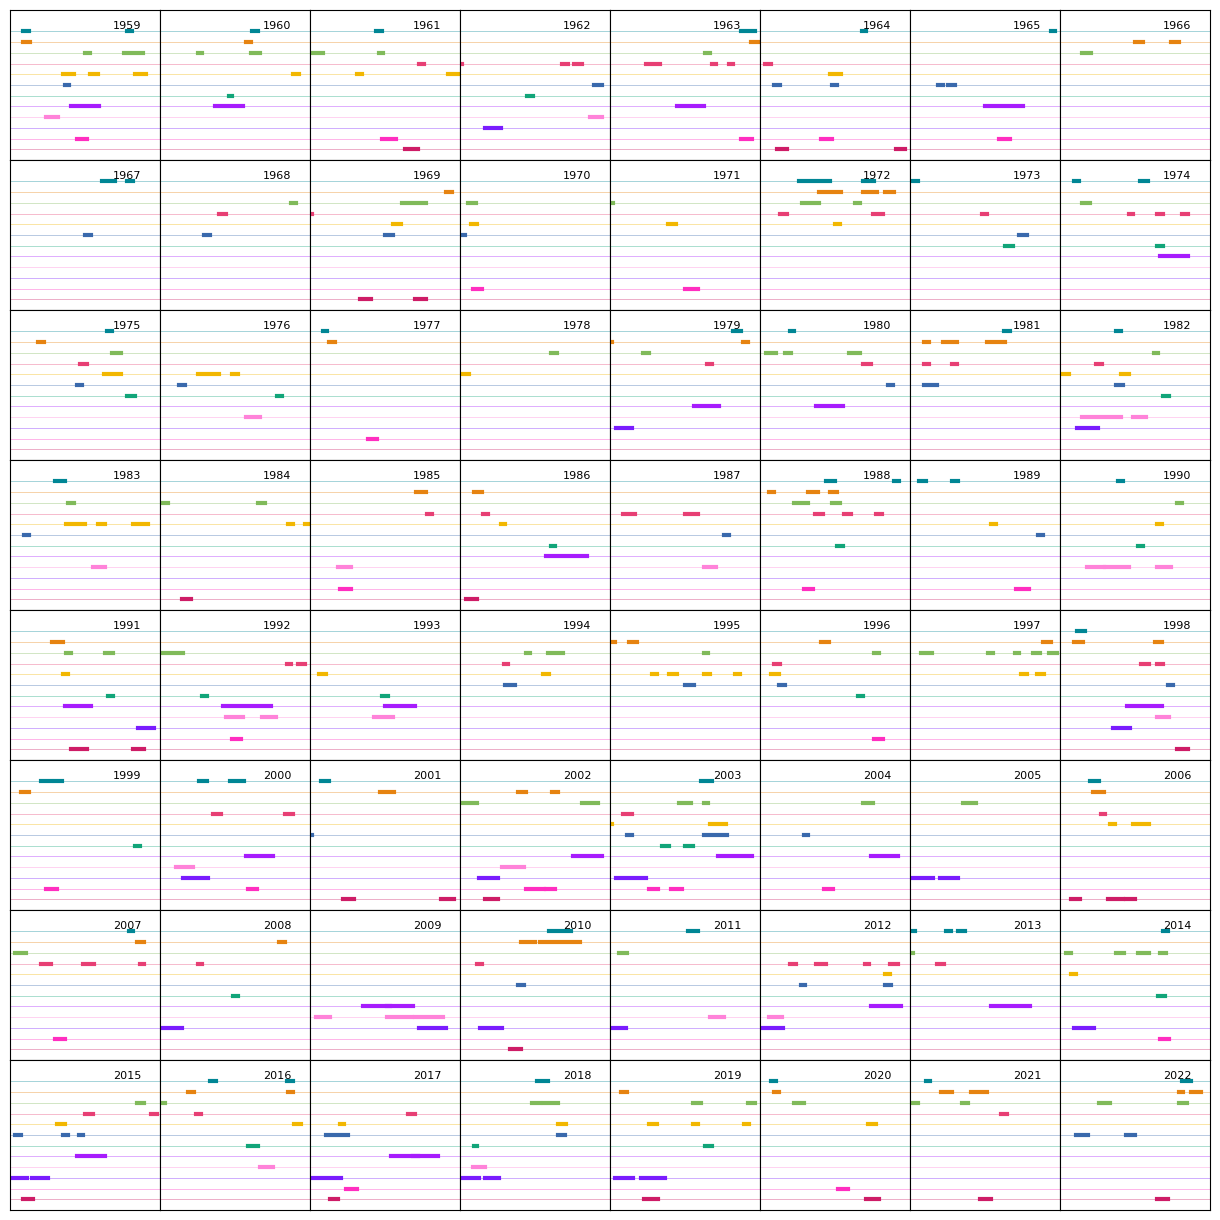

In [20]:
colors = [COLORS[3], COLORS[2], COLORS[1], COLORS_EXT[6], COLORS_EXT[1], *colormaps.bold(np.linspace(0, 1, 11))[1:]]
for spell in spells_list.values():
    print(spell["spell"].max())
fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
ax.axis("off")
for spell_name, color in zip(spells_list, colors):
    ax.plot([], [], color=color, lw=3, label=spell_name)
ax.legend()
plt.show()
fig, axes = plt.subplots(8, 8, figsize=(12, 12), gridspec_kw=dict(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1), subplot_kw=dict(xticks=[], yticks=[], xlim=[-1, 95], ylim=[-1, 13]))
axes = axes.ravel()
for ax, year in zip(axes, YEARS):
    ax.text(65, len(spells_list) - .8, f"{year}", fontsize=8)
    for j, (name_, spell) in enumerate(spells_list.items()):
        ax.plot([-1, 95], [j, j], color=colors[j], lw=.5, ls="solid", alpha=0.5)
        spell_ = spell.filter(pl.col("time").dt.year() == year)
        if len(spell_) == 0:
            continue
        for s, indiv_spell in spell_.group_by("spell"):
            x = [indiv_spell["time"].dt.ordinal_day().first() - 152, indiv_spell["time"].dt.ordinal_day().last() - 152]
            y = [j, j]
            ax.plot(x, y, color=colors[j], lw=3)    

In [47]:
overlaps = np.zeros((len(spells_list), len(spells_list)))
for i, val1 in enumerate(spells_list.values()):
    for j, val2 in enumerate(spells_list.values()):
        overlaps[i, j] = val1["time"].cast(pl.Datetime("ms")).is_in(val2["time"].cast(pl.Datetime("ms"))).mean()

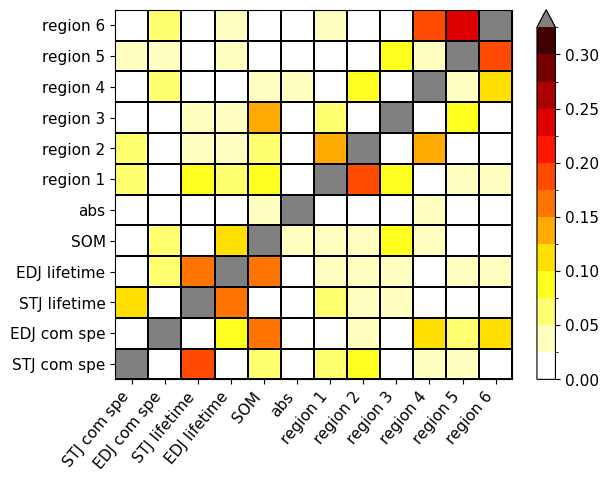

In [58]:
fig, ax = plt.subplots()
cmap = colormaps.matlab_hot_r
cmap.set_over("grey")
norm = BoundaryNorm(np.arange(0, 0.35, 0.025), cmap.N, extend="max")
im = ax.pcolormesh(overlaps, cmap=cmap, norm=norm, lw=0.1, ls="solid", edgecolor="black")
fig.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(spells_list)) + 0.5, list(spells_list), ha="right", rotation=50)
ax.set_yticks(np.arange(len(spells_list)) + 0.5, list(spells_list))
a = 1

# Natural coordinates composites

In [ ]:
# da_T = open_da(
#     "ERA5", "surf", "t2m", "dailymean", "all", "JJA", -100, 60, 0, 90, "all",
# )
# da_T = compute(da_T)
# da_tp = open_da(
#     "ERA5", "surf", "tp", "dailysum", "all", "JJA", -100, 60, 0, 90, "all",
# )
# da_tp = compute(da_tp)
# da_sst = open_da(
#     "ERA5", "surf", "sst", "dailymean", "all", "JJA", -100, 60, 0, 90, "all",
# )
# da_sst = compute(da_sst)
# da_apvs = open_da("ERA5", "thetalev", "apvs", "dailyany", "all", "JJA", -100, 60, 0, 90)
# da_apvs = compute(da_apvs)
# da_cpvs = open_da("ERA5", "thetalev", "cpvs", "dailyany", "all", "JJA", -100, 60, 0, 90)
# da_cpvs = compute(da_cpvs)

In [32]:
da_T = open_da("ERA5", "surf", "t2m", "dailymean", "all", "JJA", *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,)
da_T = compute(da_T)
da_tp = open_da("ERA5", "surf", "tp", "dailysum", "all", "JJA", *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,)
da_tp = compute(da_tp)
da_apvs = open_da("ERA5", "thetalev", "apvs", "dailyany", "all", "JJA", *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,)
da_apvs = compute(da_apvs)
da_cpvs = open_da("ERA5", "thetalev", "cpvs", "dailyany", "all", "JJA", *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,)
da_cpvs = compute(da_cpvs)

In [33]:
def symmetrize_p(pvals: xr.DataArray | np.ndarray, direction: int, q: float) -> np.ndarray:
    if direction == 0:
        return np.amin([pvals * 2, (1 - pvals) * 2], axis=0) < q
    if direction == 1:
        return np.asarray(pvals) > 1 - q
    return np.asarray(pvals) < q


def plot_all_relative_composites(jets, times, variable_dict, n_bootstraps: int = 50):
    figs = []
    for varname, props in variable_dict.items():
        if len(props) == 3:
            da, nlevels, cmap = props
            clim = None
        else:
            da, clim, nlevels, cmap = props
        hatch = "xxx" if varname == "tp" else "xx"
        
        jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(jets, times, da, n_bootstraps=n_bootstraps, clim=clim)
        try:
            to_plot = jets_during_spells_with_interp_norm_ds[da.name + "_interp"]
            pvals = jets_during_spells_with_interp_norm_ds["pvals"]
        except KeyError:
            to_plot = jets_during_spells_with_interp_norm_ds
            
        direction = infer_direction(to_plot)
        symmetric = direction == 0

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        levels = MaxNLocator(nlevels, symmetric=symmetric).tick_values(to_plot.quantile(0.01), to_plot.quantile(0.99))
        norm = BoundaryNorm(levels, cmap.N)
        
        axes[0].pcolormesh(to_plot.norm_index, to_plot.n, to_plot[0].T, norm=norm, cmap=cmap)
        filter_ = symmetrize_p(pvals[0].T, direction, 0.05)
        axes[0].pcolor(pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.)
        
        axes[1].pcolormesh(to_plot.norm_index, to_plot.n, to_plot[1].T, norm=norm, cmap=cmap)
        filter_ = symmetrize_p(pvals[1].T, direction, 0.05)
        axes[1].pcolor(pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.)

        fig.colorbar(ScalarMappable(norm, cmap), ax=axes, spacing="proportional")
        figs.append(fig)
    return figs

# clim_T = xr.open_dataarray(exp.path.joinpath("t2m_relative_clim.nc"))
# clim_tp = xr.open_dataarray(exp.path.joinpath("tp_relative_clim.nc"))
# clim_apvs = xr.open_dataarray(exp.path.joinpath("apvs_relative_clim.nc"))
# clim_cpvs = xr.open_dataarray(exp.path.joinpath("cpvs_relative_clim.nc"))
# clim_sst = xr.open_dataarray(exp.path.joinpath("sst_relative_clim.nc"))

# variable_dict = {
#     "t2m": [da_T, clim_T, 8, colormaps.BlWhRe],
#     "tp": [da_tp, clim_tp, 15, colormaps.precip4_diff_19lev],
#     "APVS": [da_apvs, clim_apvs, 7, colormaps.curl],
#     "CPVS": [da_cpvs, clim_cpvs, 7, colormaps.curl],
#     "sst": [da_sst, clim_sst, 7, colormaps.BlWhRe]
# }
variable_dict = {
    "t2m": [da_T, 8, colormaps.BlWhRe],
    "tp": [da_tp, 15, colormaps.precip4_diff_19lev],
    "APVS": [da_apvs, 7, colormaps.curl],
    "CPVS": [da_cpvs, 7, colormaps.curl],
}

## Mean anomaly at onset

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

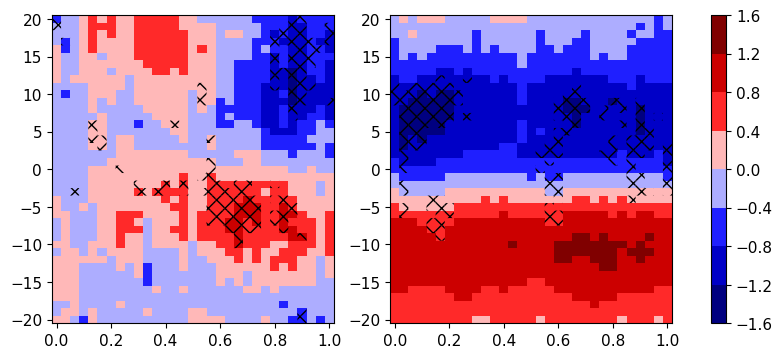

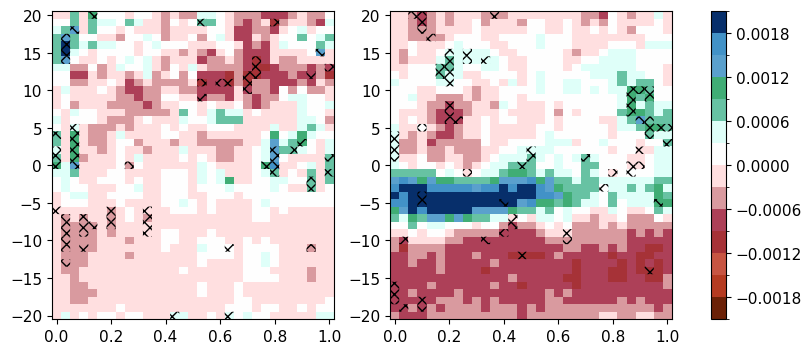

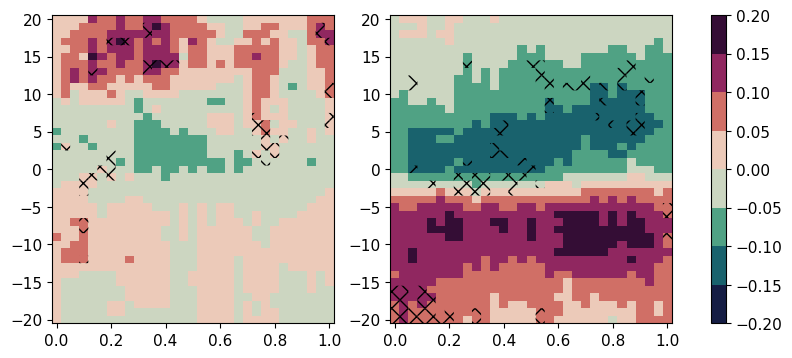

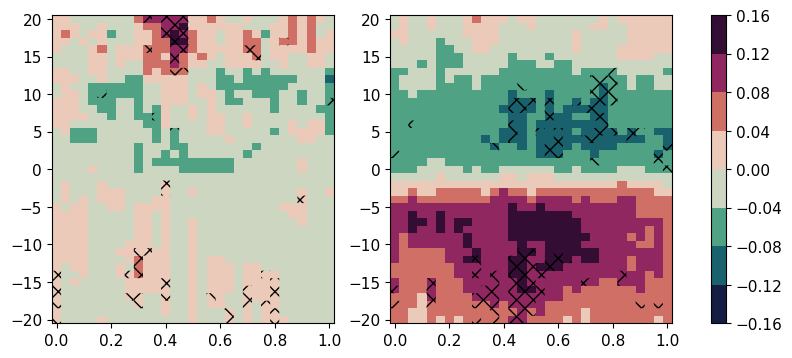

In [34]:
spells_from_jet = spells_list_time_before["EDJ lifetime"]
spells_from_jet = subset_around_onset(spells_from_jet, around_onset=datetime.timedelta(days=1))
jets = all_jets_one_df.filter(pl.col("time").dt.hour() == 0, pl.col("time").dt.month().is_in([6, 7, 8]))

plot_all_relative_composites(jets, spells_from_jet, variable_dict, 50)

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

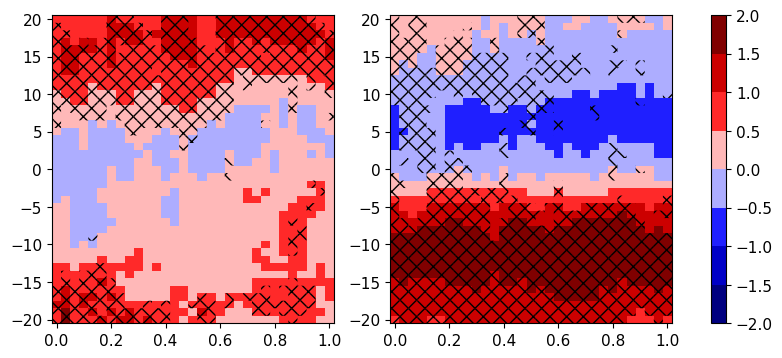

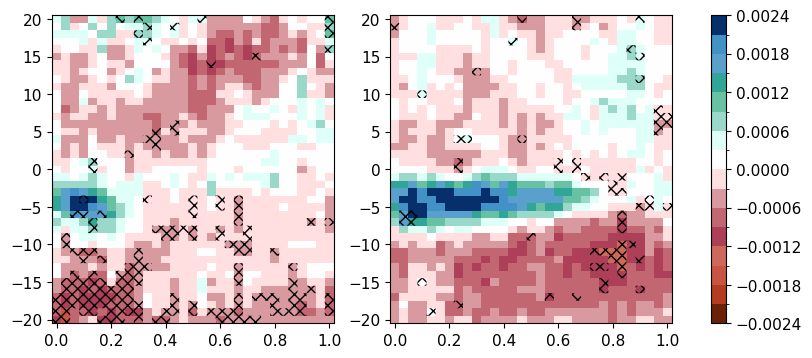

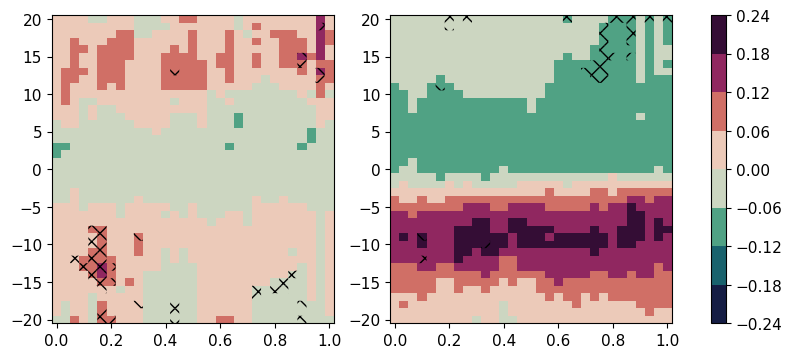

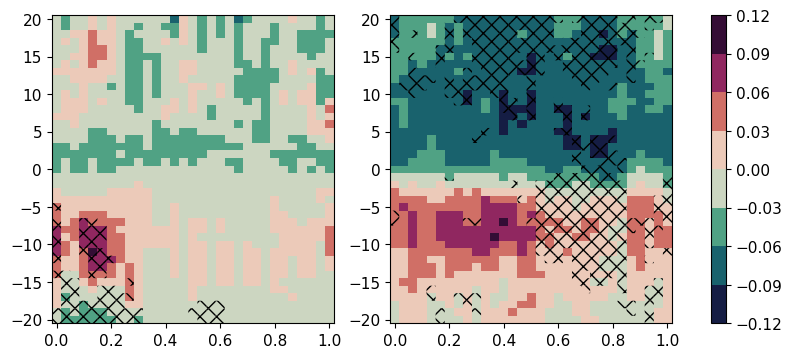

In [35]:
spells_from_jet = spells_list_time_before["STJ lifetime"]
spells_from_jet = subset_around_onset(spells_from_jet, around_onset=datetime.timedelta(days=1))
jets = all_jets_one_df.filter(pl.col("time").dt.hour() == 0, pl.col("time").dt.month().is_in([6, 7, 8]))

plot_all_relative_composites(jets, spells_from_jet, variable_dict, 50)

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

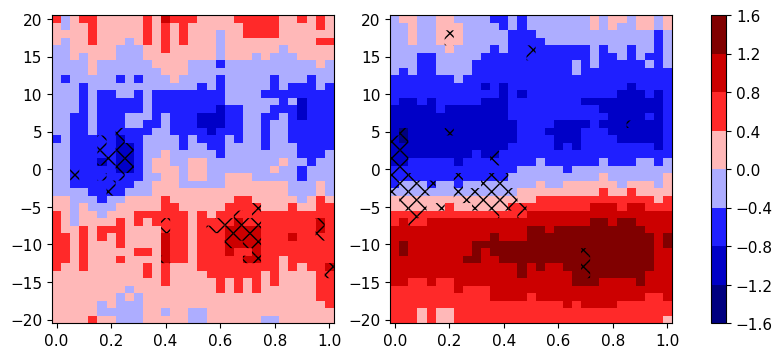

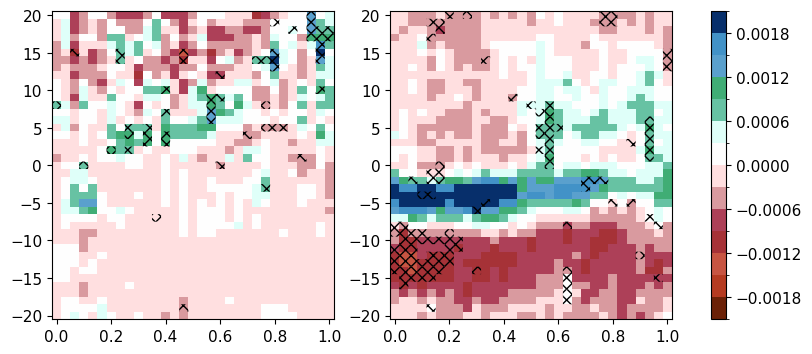

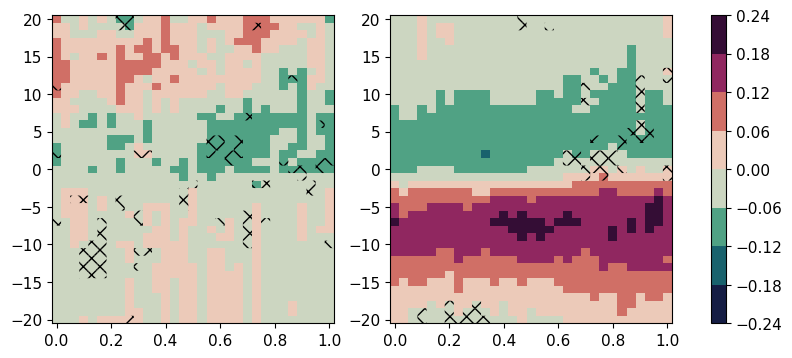

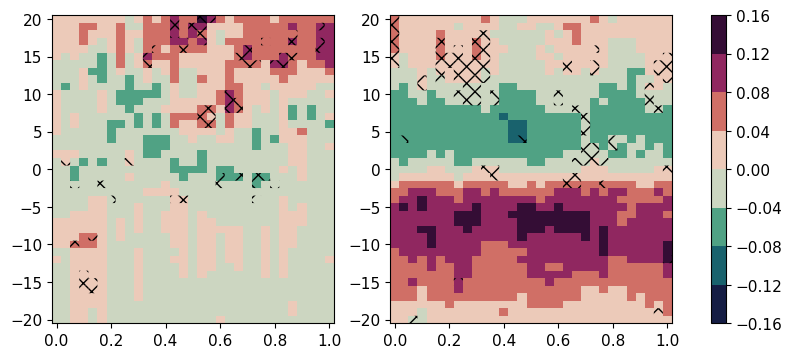

In [36]:
spells_from_jet = spells_list_time_before["EDJ com spe"]
spells_from_jet = subset_around_onset(spells_from_jet, around_onset=datetime.timedelta(days=1))
jets = all_jets_one_df.filter(pl.col("time").dt.hour() == 0, pl.col("time").dt.month().is_in([6, 7, 8]))

plot_all_relative_composites(jets, spells_from_jet, variable_dict, 50)

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

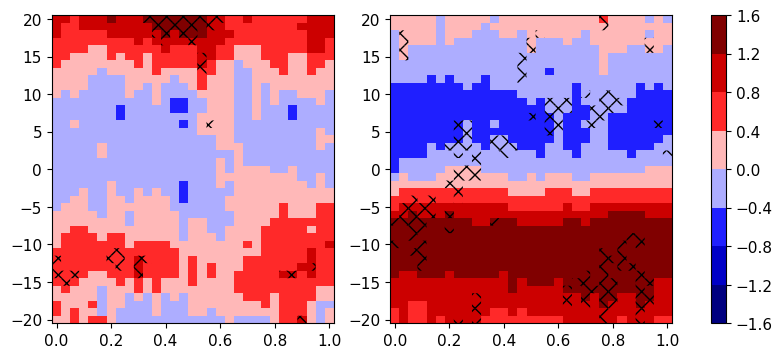

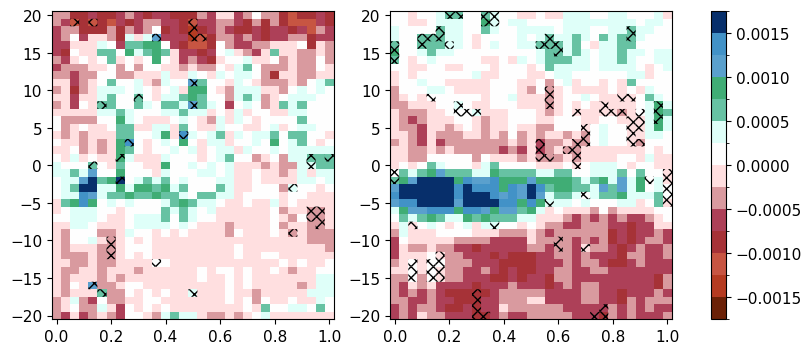

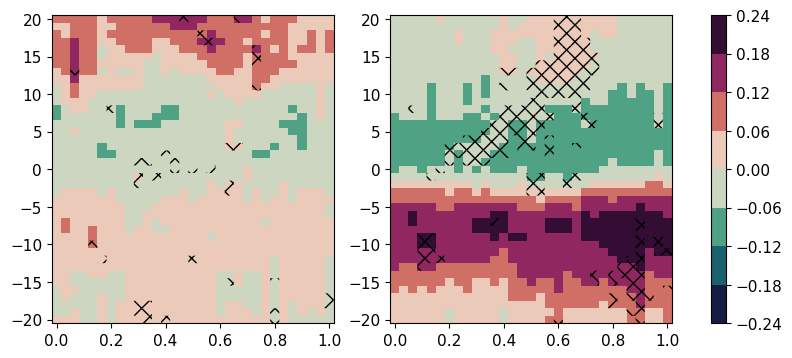

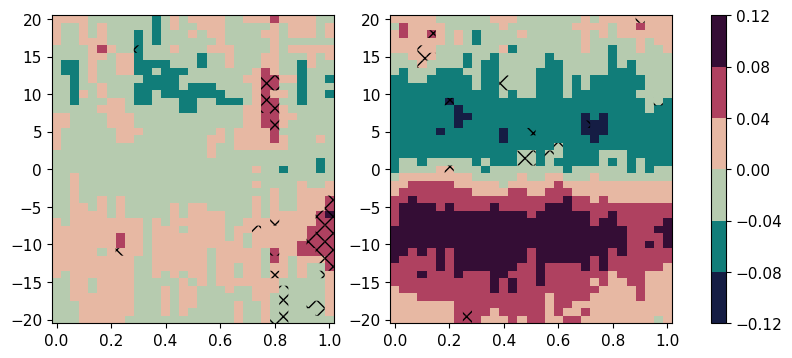

In [37]:
spells_from_jet = spells_list_time_before["STJ com spe"]
spells_from_jet = subset_around_onset(spells_from_jet, around_onset=datetime.timedelta(days=1))
jets = all_jets_one_df.filter(pl.col("time").dt.hour() == 0, pl.col("time").dt.month().is_in([6, 7, 8]))

plot_all_relative_composites(jets, spells_from_jet, variable_dict, 50)

## jet coordinate time series: hovmoller time x normal, one for each half of the jet...

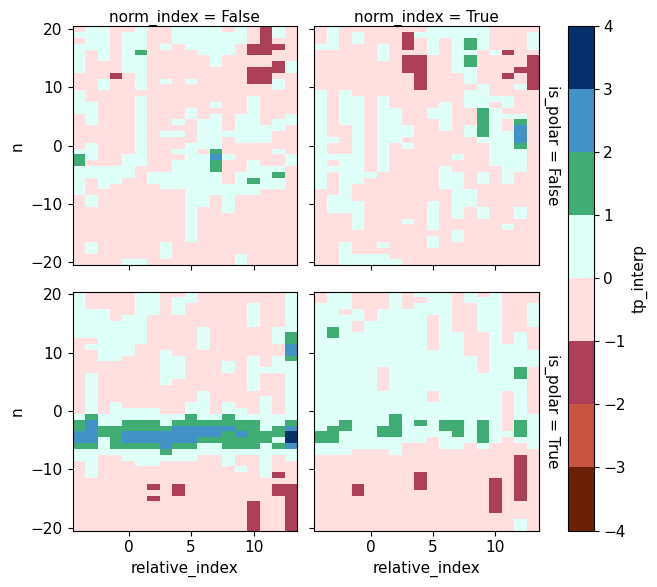

In [48]:
spells_from_jet = spells_list_time_before["EDJ lifetime"]
jets_with_interp = _gather_normal_da_jets_wrapper(jets, spells_from_jet, da_tp)
tentative = jets_with_interp.group_by(pl.col("is_polar") > 0.5, "relative_index", "relative_time", pl.col("norm_index") > 0.5, "n", maintain_order=True).agg(pl.col("tp_interp").mean())
(1000 * polars_to_xarray(tentative, index_columns=["is_polar", "norm_index", "relative_index", "n"])["tp_interp"][:, :, :18]).plot(row="is_polar", col="norm_index", x="relative_index", y="n", levels=8, cmap=colormaps.precip4_diff_19lev, extend="neither")

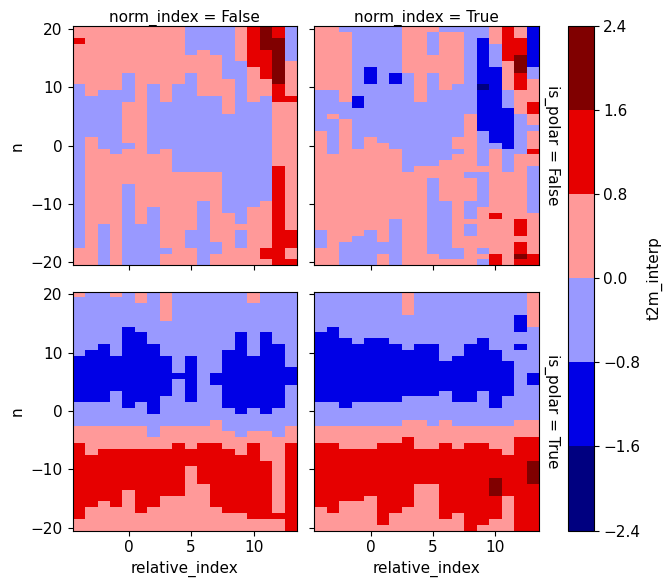

In [50]:
spells_from_jet = spells_list_time_before["EDJ lifetime"]
jets_with_interp = _gather_normal_da_jets_wrapper(jets, spells_from_jet, da_T)
tentative = jets_with_interp.group_by(pl.col("is_polar") > 0.5, "relative_index", "relative_time", pl.col("norm_index") > 0.5, "n", maintain_order=True).agg(pl.col("t2m_interp").mean())
polars_to_xarray(tentative, index_columns=["is_polar", "norm_index", "relative_index", "n"])["t2m_interp"][:, :, :18].plot(row="is_polar", col="norm_index", x="relative_index", y="n", levels=8, cmap=colormaps.BlWhRe)

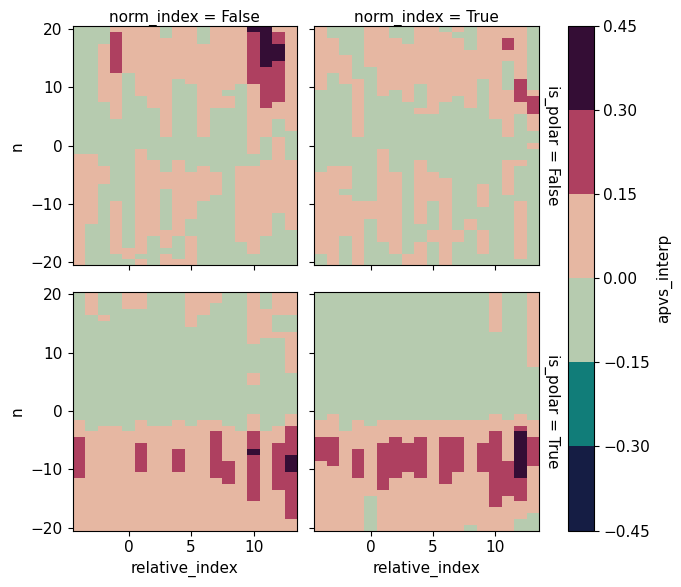

In [51]:
spells_from_jet = spells_list_time_before["EDJ lifetime"]
jets_with_interp = _gather_normal_da_jets_wrapper(jets, spells_from_jet, da_apvs)
tentative = jets_with_interp.group_by(pl.col("is_polar") > 0.5, "relative_index", "relative_time", pl.col("norm_index") > 0.5, "n", maintain_order=True).agg(pl.col("apvs_interp").mean())
polars_to_xarray(tentative, index_columns=["is_polar", "norm_index", "relative_index", "n"])["apvs_interp"][:, :, :18].plot(row="is_polar", col="norm_index", x="relative_index", y="n", levels=8, cmap=colormaps.curl)

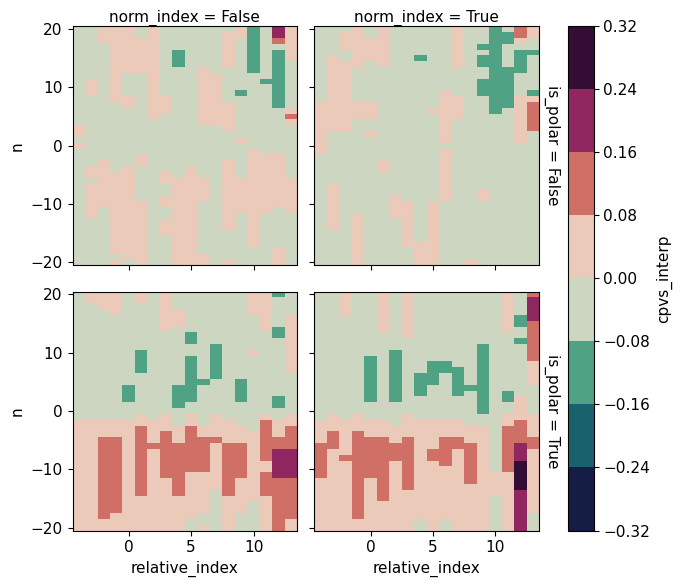

In [53]:
spells_from_jet = spells_list_time_before["EDJ lifetime"]
jets_with_interp = _gather_normal_da_jets_wrapper(jets, spells_from_jet, da_cpvs)
tentative = jets_with_interp.group_by(pl.col("is_polar") > 0.5, "relative_index", "relative_time", pl.col("norm_index") > 0.5, "n", maintain_order=True).agg(pl.col("cpvs_interp").mean())
polars_to_xarray(tentative, index_columns=["is_polar", "norm_index", "relative_index", "n"])["cpvs_interp"][:, :, :18].plot(row="is_polar", col="norm_index", x="relative_index", y="n", levels=8, cmap=colormaps.curl)

# case studies

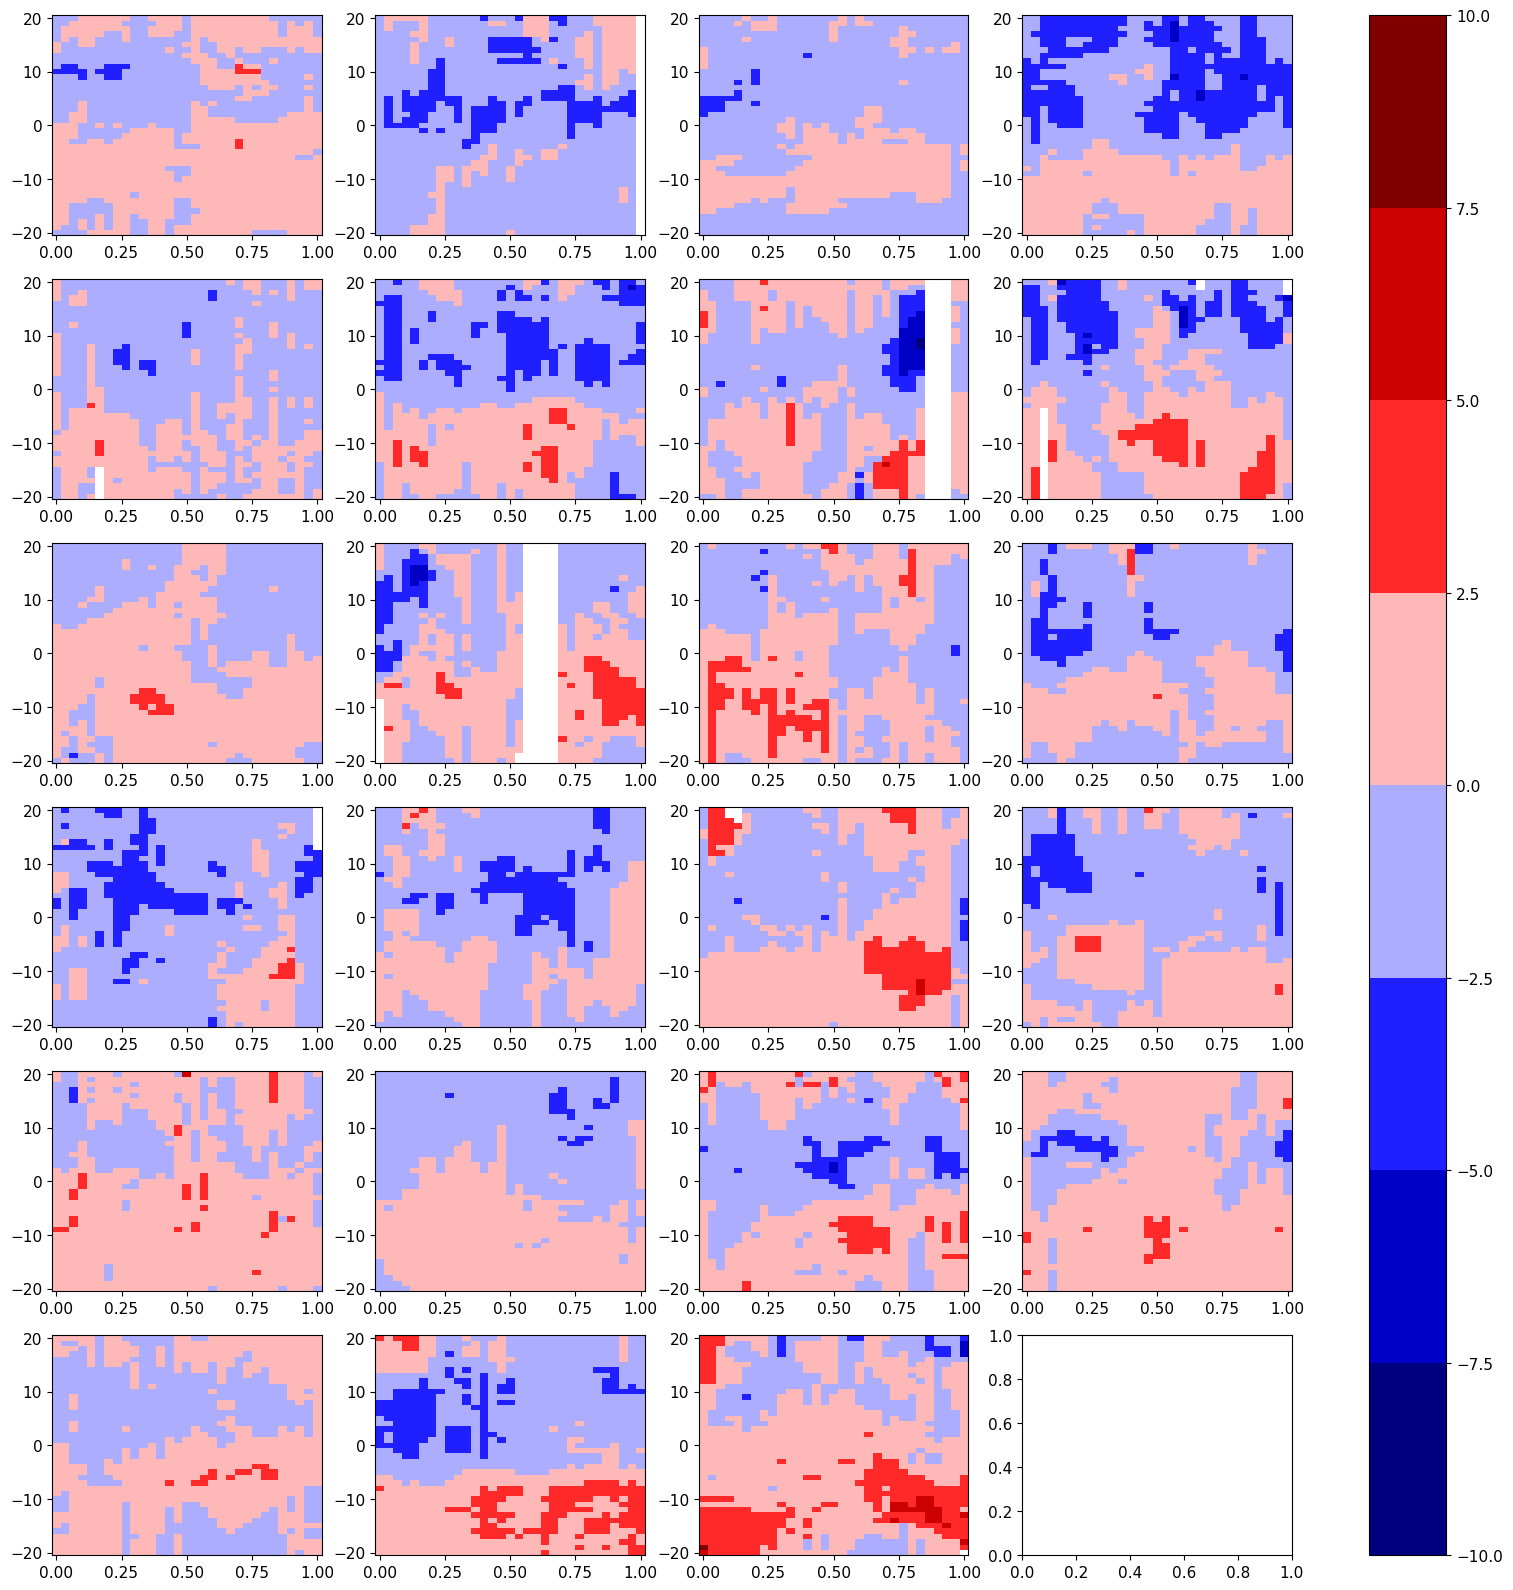

In [61]:
spells_onset = spells_list_time_before["EDJ lifetime"]
spells_onset = subset_around_onset(spells_onset, 0)
jets = all_jets_one_df.filter(pl.col("time").dt.hour() == 0, pl.col("time").dt.month().is_in([6, 7, 8]))
da = da_T

jets = _gather_normal_da_jets_wrapper(jets, spells_onset, da)
varname = da.name + "_interp"
jets = jets.group_by([pl.col("is_polar") > 0.5, "norm_index", "n", "spell"], maintain_order=True).agg(pl.col(varname).mean())
jets = polars_to_xarray(jets, ["is_polar", "norm_index", "n", "spell"])
fig, axes = plt.subplots(6, 4, figsize=(20, 20))
axes = axes.flatten()
cmap = colormaps.BlWhRe
norm = BoundaryNorm(MaxNLocator(8).tick_values(jets.min(), jets.max()), cmap.N)
for i in range(jets["spell"].max().item()):
    ax = axes[i]
    ax.pcolormesh(jets.norm_index, jets.n, jets[1, :, :, i].T, cmap=cmap, norm=norm)
fig.colorbar(ScalarMappable(norm, cmap), ax=axes)

# Relative time series

23


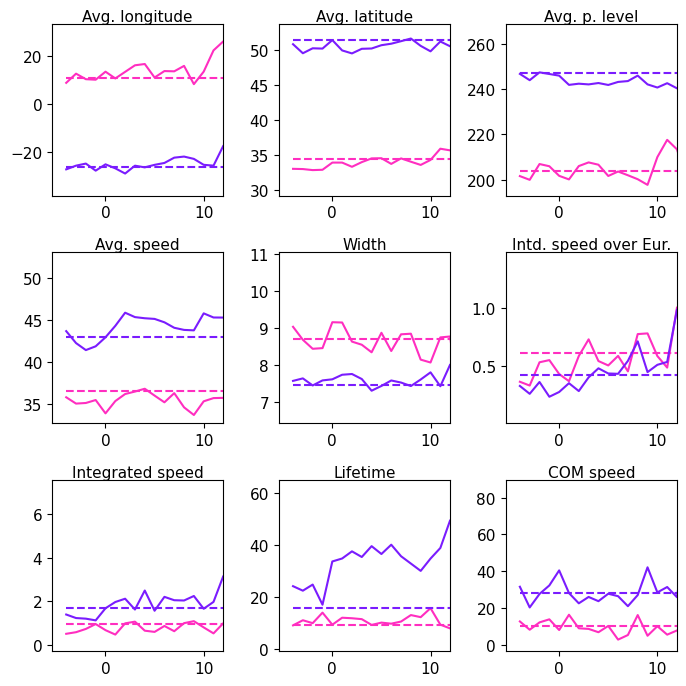

In [4]:
spells_from_jet = spells_list_time_before["EDJ lifetime"]
props_masked = mask_from_spells_pl(spells_from_jet, props_as_df)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "int_over_europe", "int", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
        factor = 1e5 if data_var == "width" else factor
        ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j])
        mean = means[j, data_var] / factor
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
for ax in axes:
    ax.set_xlim([ax.get_xlim()[0], 12])
print(props_masked["spell"].max())
fig.set_tight_layout(True)
fig.savefig(f"{FIGURES}/persistent_spells/props_edj_persistence.png")

22


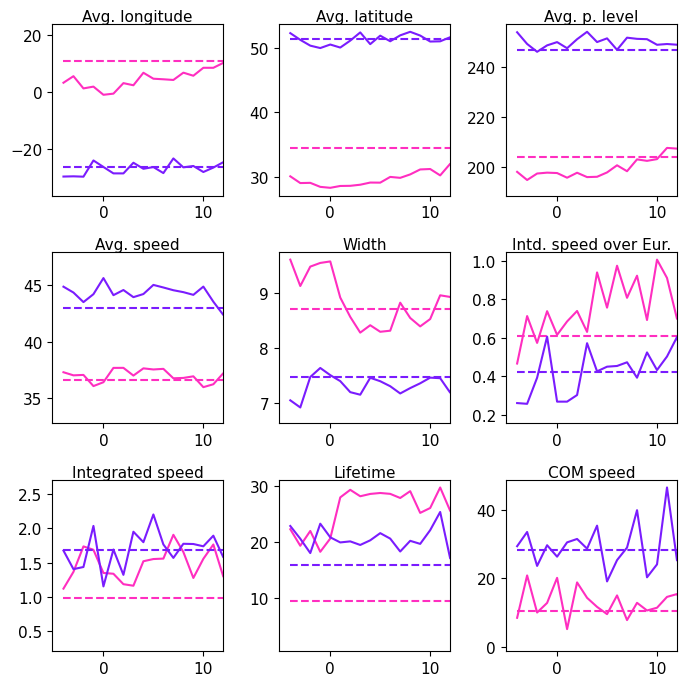

In [5]:
spells_from_jet = spells_list_time_before["STJ lifetime"]
props_masked = mask_from_spells_pl(spells_from_jet, props_as_df)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "int_over_europe", "int", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
        factor = 1e5 if data_var == "width" else factor
        ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j])
        mean = means[j, data_var] / factor
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
for ax in axes:
    ax.set_xlim([ax.get_xlim()[0], 12])
print(props_masked["spell"].max())
fig.set_tight_layout(True)
fig.savefig(f"{FIGURES}/persistent_spells/props_stj_persistence.png")

# Relative anomaly time series

In [11]:
props_anom = compute_anomalies_pl(props_as_df, smooth_clim=7 * 4, normalize=True)

23


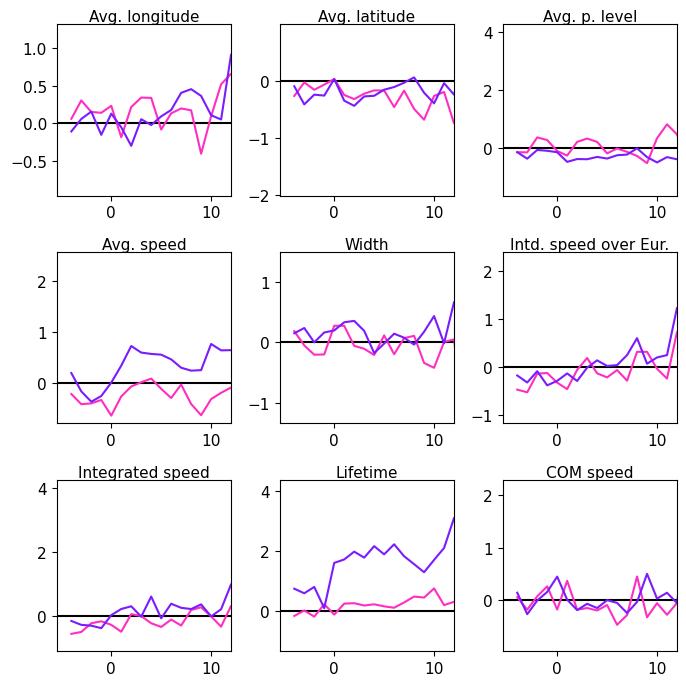

In [ ]:
spells_from_jet = spells_list_time_before["EDJ lifetime"]
props_masked = mask_from_spells_pl(spells_from_jet, props_anom)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "int_over_europe", "int", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7), tight_layout=True)
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
for ax in axes:
    xlim = ax.get_xlim()
    ax.plot(xlim, [0, 0], color="black", zorder=-1)
    ax.set_xlim([xlim[0], 12])
print(props_masked["spell"].max())
fig.savefig(f"{FIGURES}/persistent_spells/props_anom_edj_persistence.png")

22


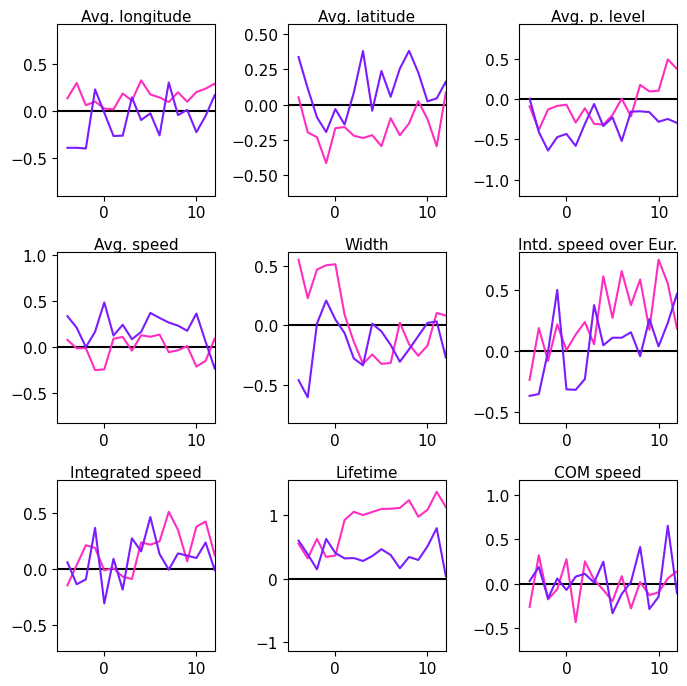

In [15]:
spells_from_jet = spells_list_time_before["STJ lifetime"]
props_masked = mask_from_spells_pl(spells_from_jet, props_anom)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "int_over_europe", "int", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7), tight_layout=True)
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
for ax in axes:
    xlim = ax.get_xlim()
    ax.plot(xlim, [0, 0], color="black", zorder=-1)
    ax.set_xlim([xlim[0], 12])
print(props_masked["spell"].max())
fig.savefig(f"{FIGURES}/persistent_spells/props_anom_stj_persistence.png")

23


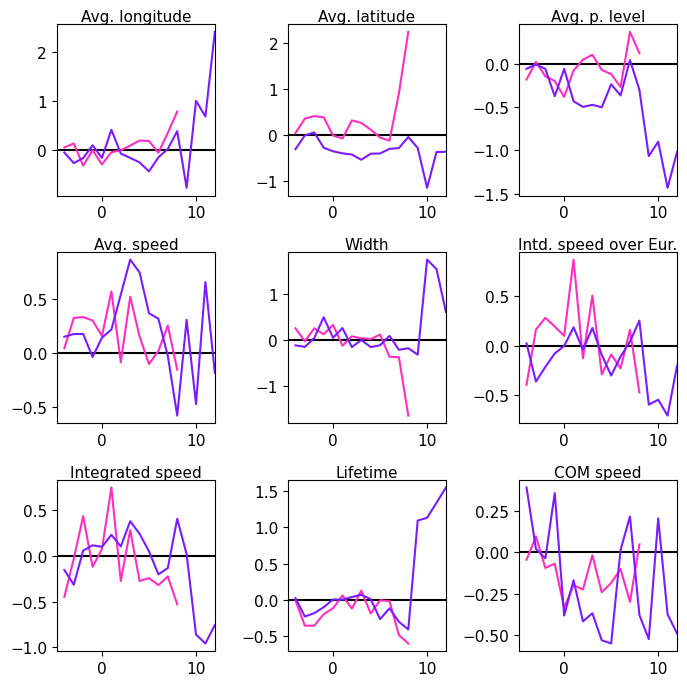

In [16]:
spells_from_jet = spells_list_time_before["EDJ com spe"]
props_masked = mask_from_spells_pl(spells_from_jet, props_anom)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "int_over_europe", "int", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7), tight_layout=True)
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
for ax in axes:
    xlim = ax.get_xlim()
    ax.plot(xlim, [0, 0], color="black", zorder=-1)
    ax.set_xlim([xlim[0], 12])
print(props_masked["spell"].max())
fig.savefig(f"{FIGURES}/persistent_spells/props_anom_edj_cs.png")

22


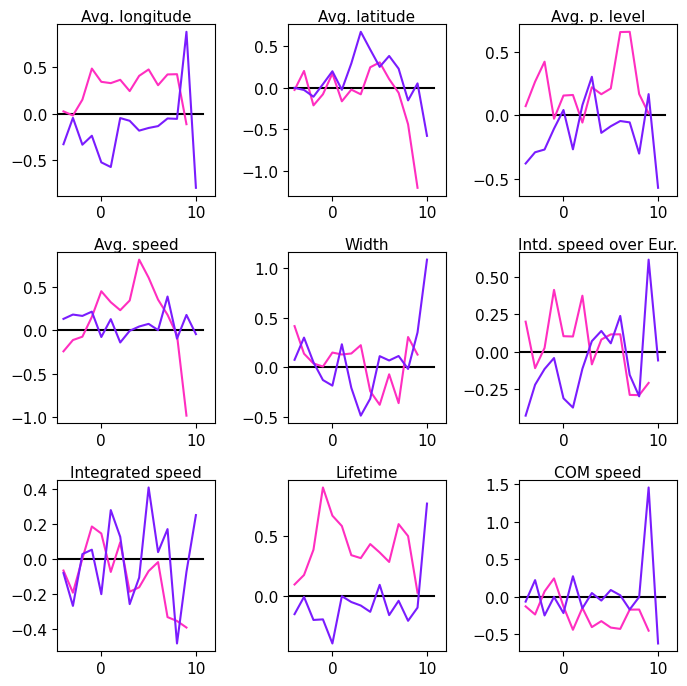

In [17]:
spells_from_jet = spells_list_time_before["STJ com spe"]
props_masked = mask_from_spells_pl(spells_from_jet, props_anom)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "int_over_europe", "int", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7), tight_layout=True)
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
for ax in axes:
    xlim = ax.get_xlim()
    ax.plot(xlim, [0, 0], color="black", zorder=-1)
    ax.set_xlim([xlim[0], 12])
print(props_masked["spell"].max())
fig.savefig(f"{FIGURES}/persistent_spells/props_anom_stj_cs.png")

# Relative time composites

In [ ]:
da_T = open_da("ERA5", "surf", "t2m", "dailymean", "all", "JJA", *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,)
da_T = compute(da_T)
da_tp = open_da("ERA5", "surf", "tp", "dailysum", "all", "JJA", *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,)
da_tp = compute(da_tp)
da_apvs = open_da("ERA5", "thetalev", "apvs", "dailyany", "all", "JJA", *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,)
da_apvs = compute(da_apvs)
da_cpvs = open_da("ERA5", "thetalev", "cpvs", "dailyany", "all", "JJA", *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,)
da_cpvs = compute(da_cpvs)

23
24


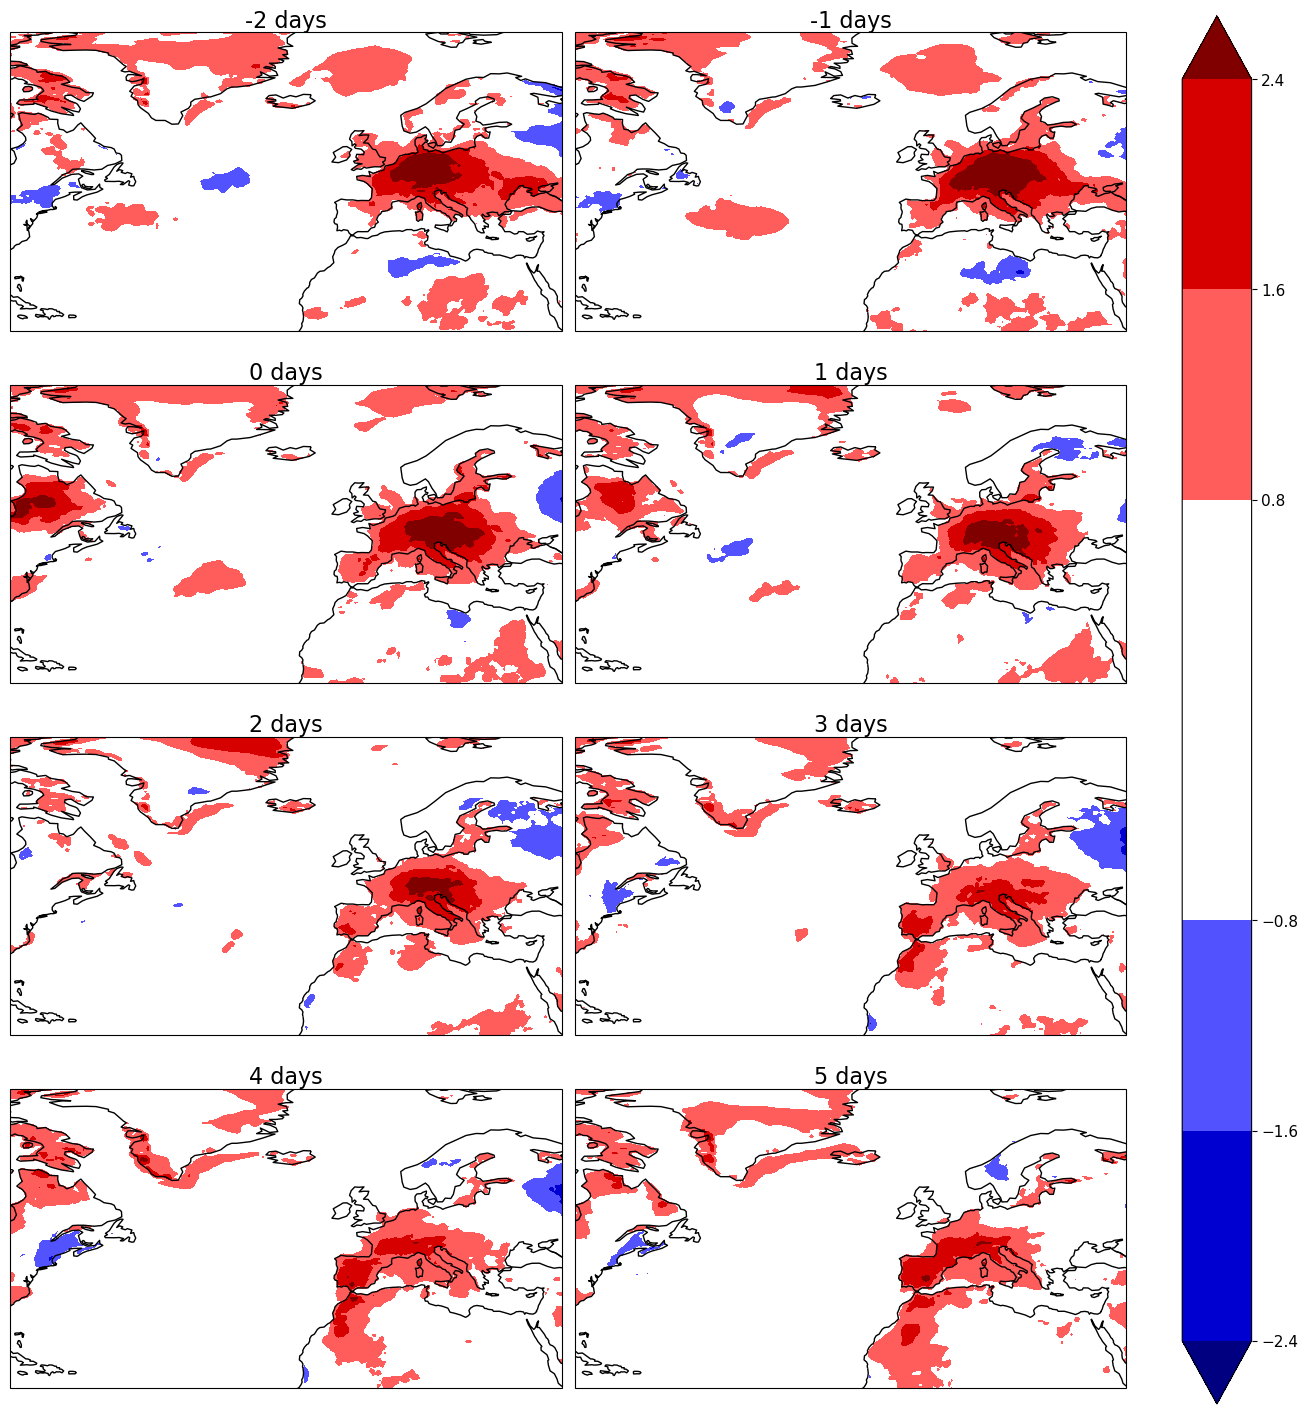

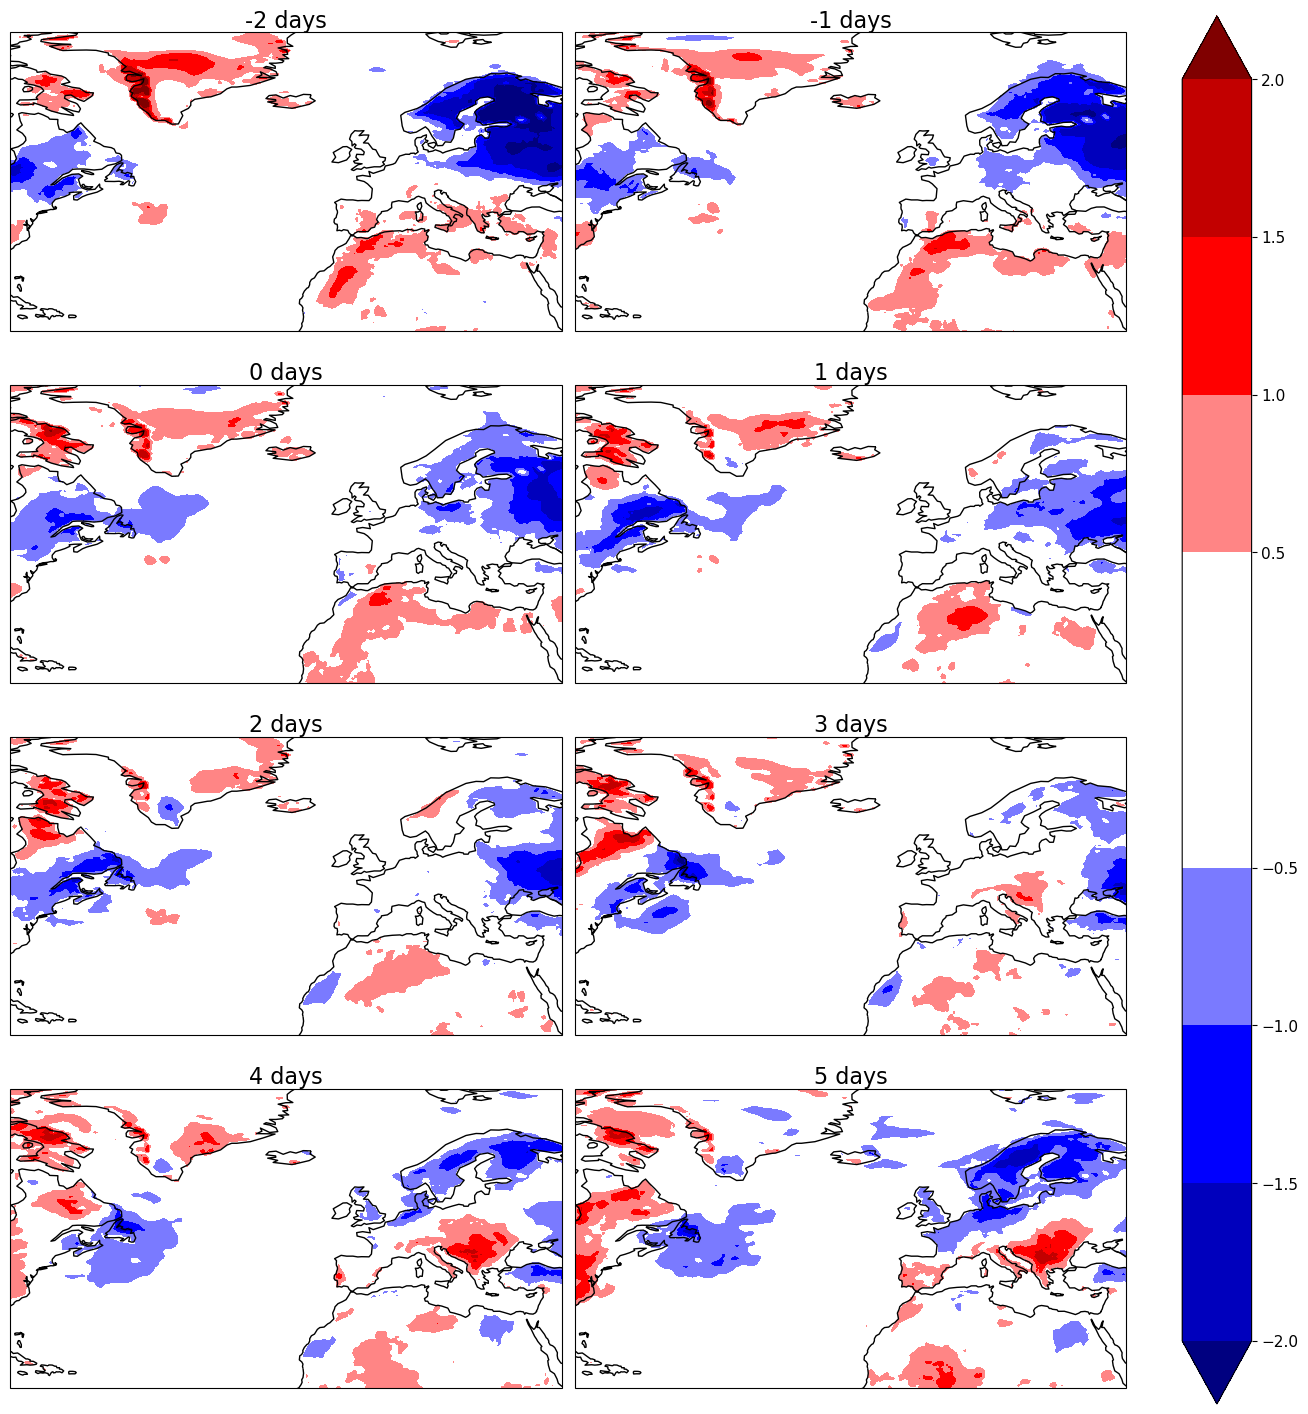

In [26]:
da = da_T.copy()
da = compute(da.sel(time=da.time.dt.season == "JJA"))
plot_kwargs = {
    "cmap": colormaps.BlWhRe,
    "levels": 7
}

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["STJ lifetime"]
to_plot = mask_from_spells_pl(spells_from_jet_daily, da)
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])
_ = clu.add_contourf(
    to_plot,
    titles=to_plot.relative_time.values.astype("timedelta64[D]"),
    **plot_kwargs
)

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["EDJ lifetime"]
to_plot = mask_from_spells_pl(spells_from_jet_daily, da)
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])
_ = clu.add_contourf(
    to_plot,
    titles=to_plot.relative_time.values.astype("timedelta64[D]"),
    **plot_kwargs
)

23
24


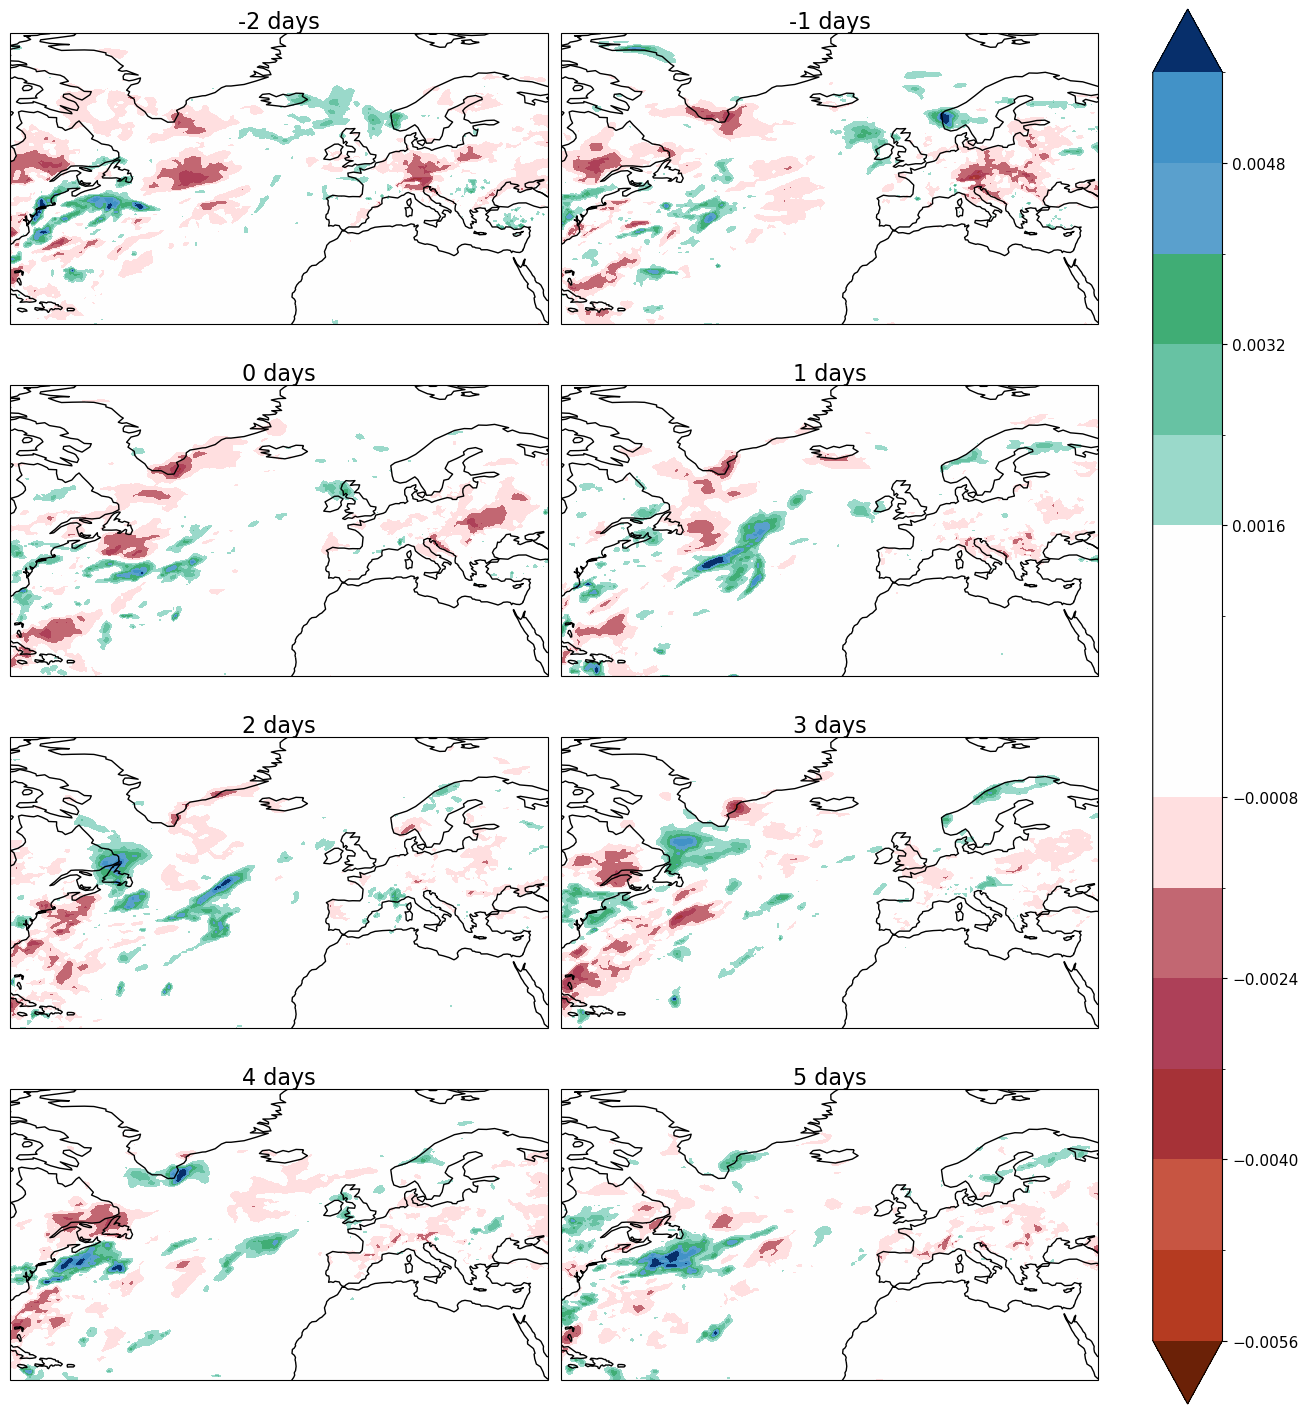

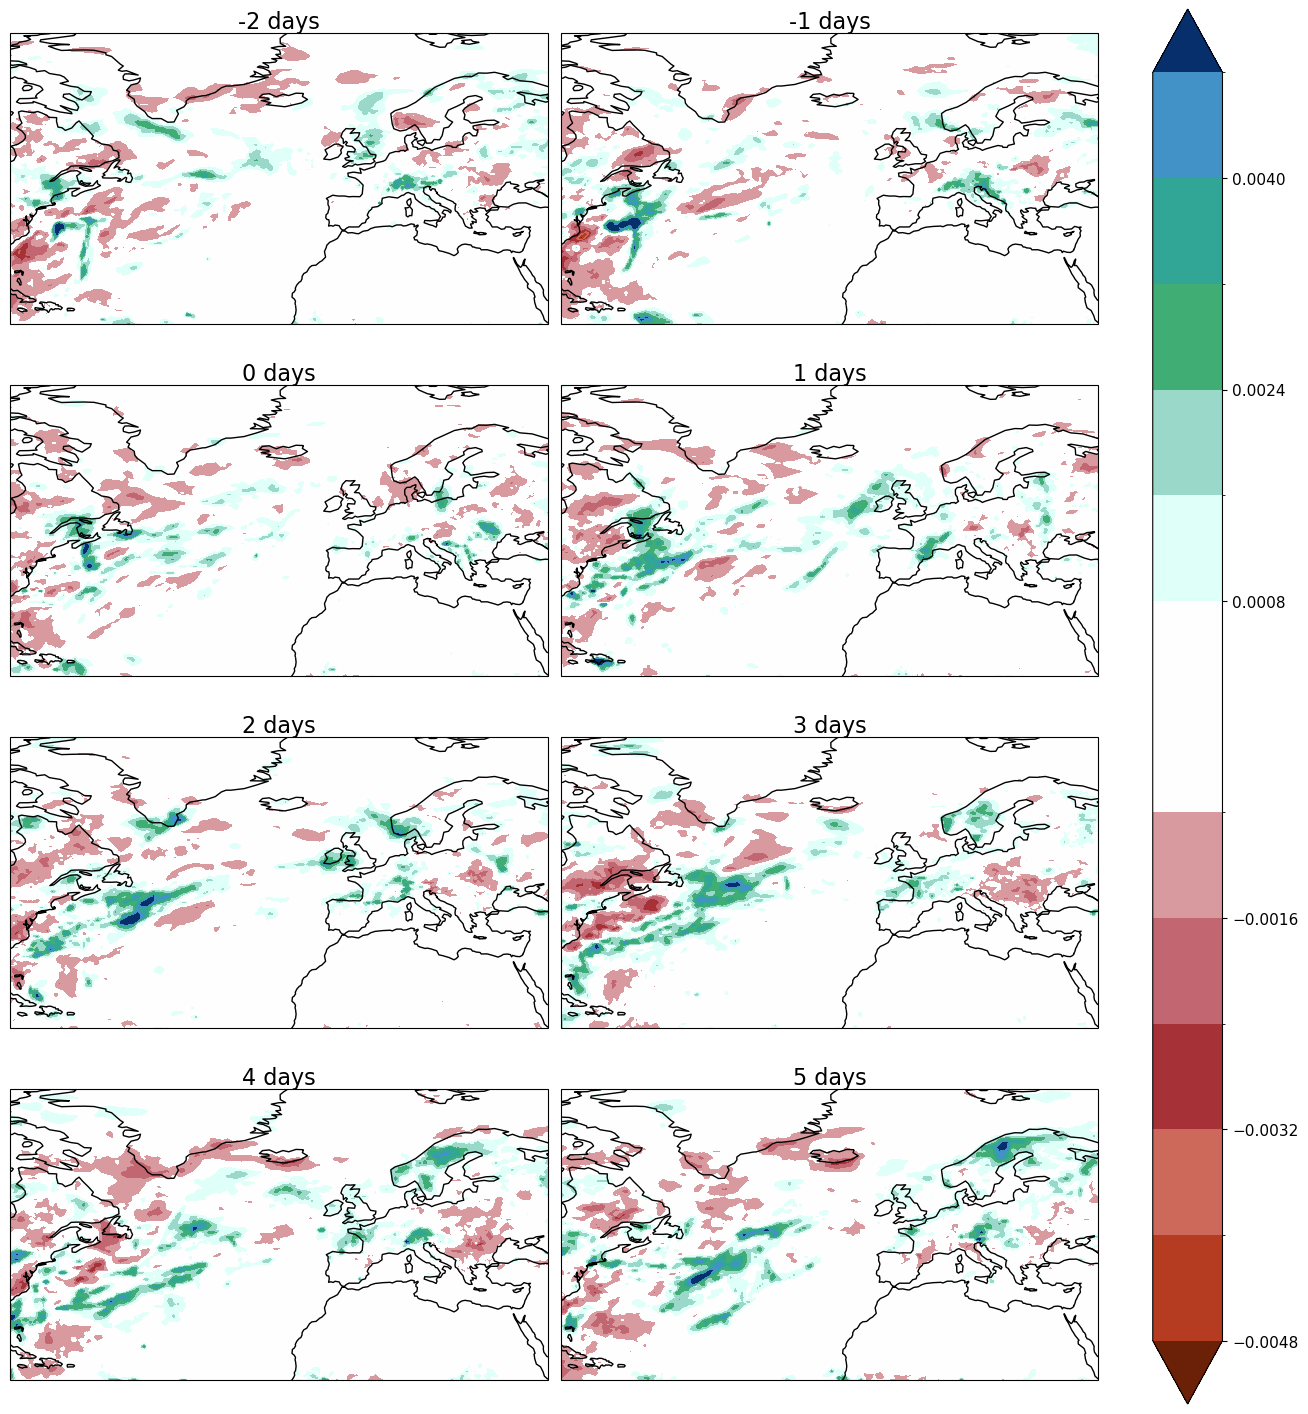

In [27]:
da = da_tp.copy()
da = compute(da.sel(time=da.time.dt.season == "JJA"))
plot_kwargs = {
    "cmap": colormaps.precip4_diff_19lev,
    "levels": 13,
    "q": 0.999,
    "transparify": 0,
}

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["STJ lifetime"]
to_plot = mask_from_spells_pl(spells_from_jet_daily, da)
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])
_ = clu.add_contourf(
    to_plot,
    titles=to_plot.relative_time.values.astype("timedelta64[D]"),
    **plot_kwargs
)

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["EDJ lifetime"]
to_plot = mask_from_spells_pl(spells_from_jet_daily, da)
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])
_ = clu.add_contourf(
    to_plot,
    titles=to_plot.relative_time.values.astype("timedelta64[D]"),
    **plot_kwargs
)

23
24


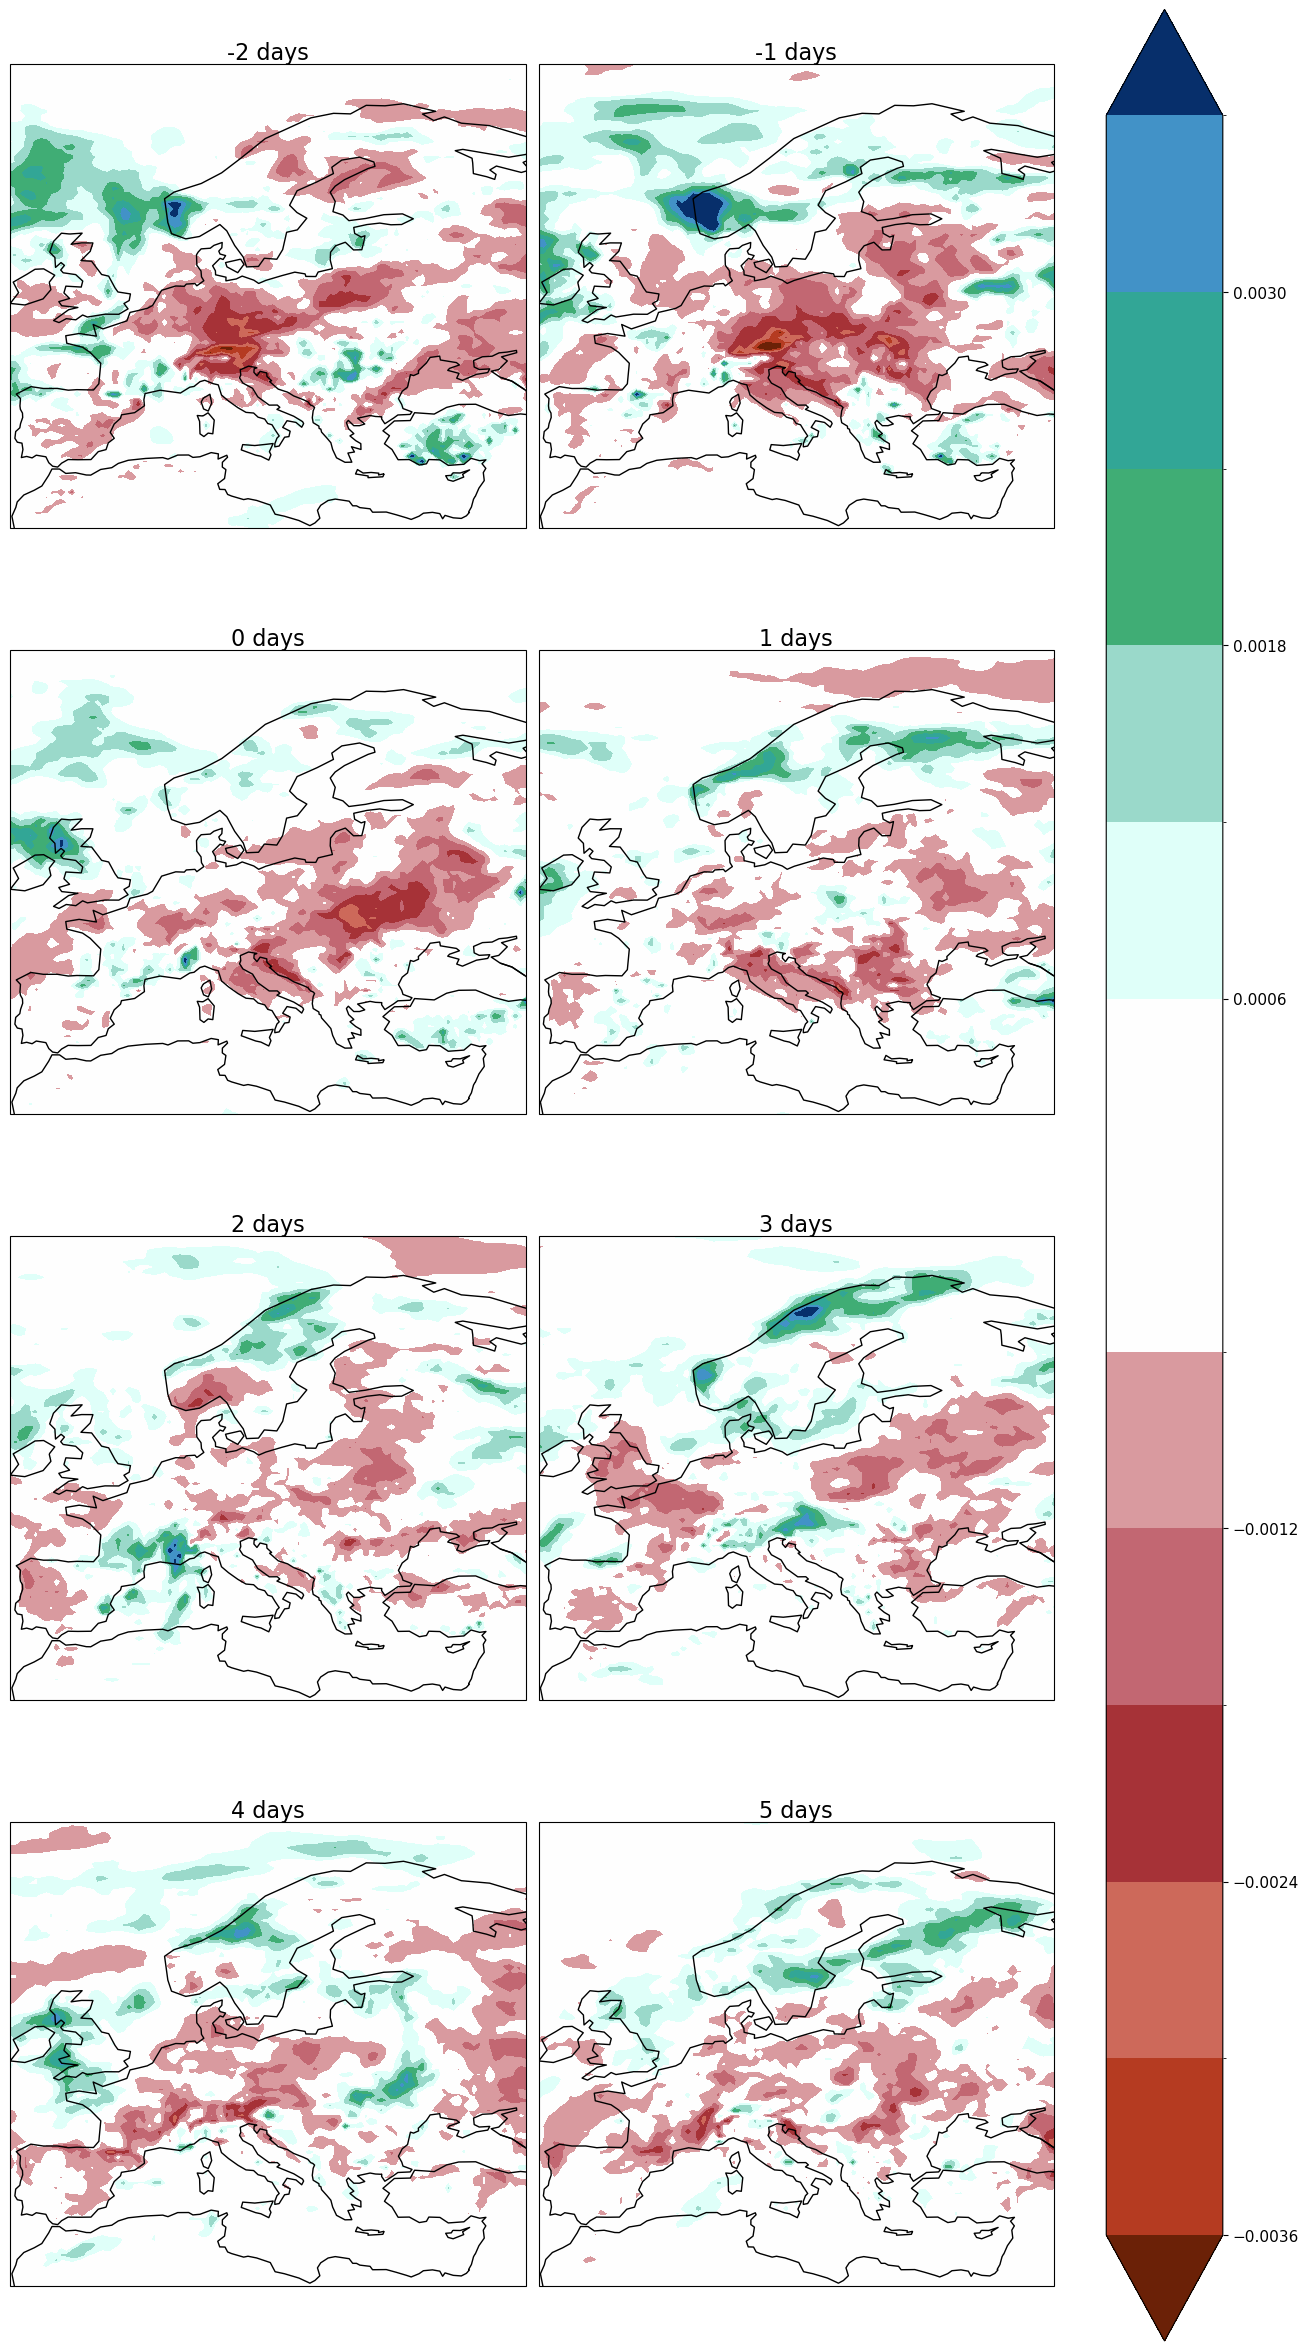

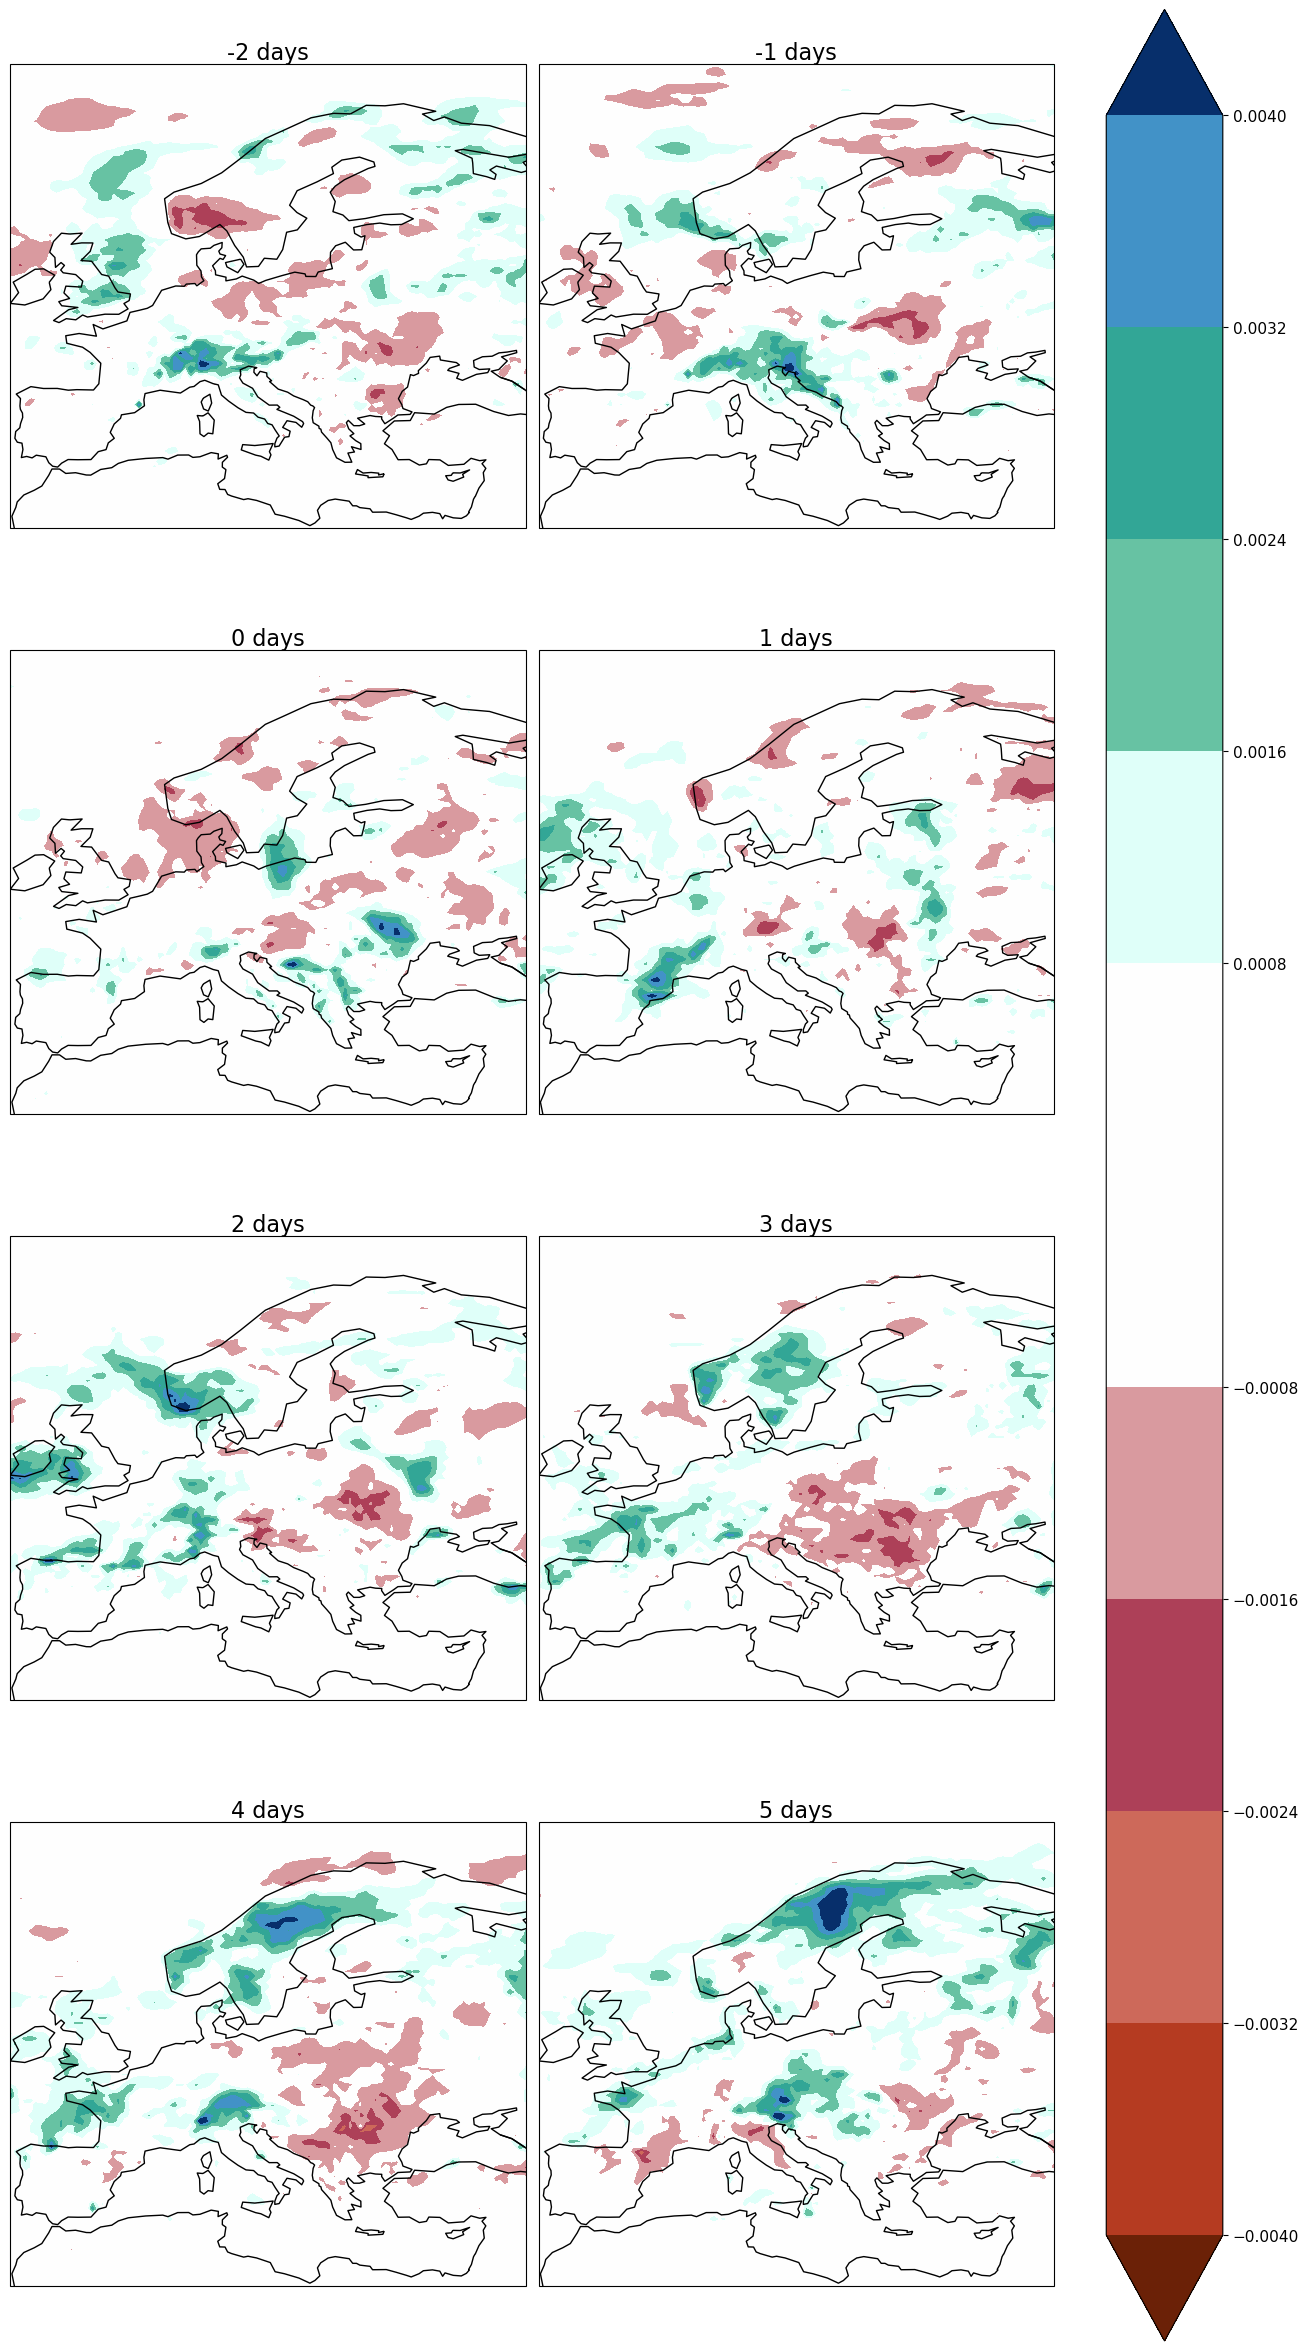

In [28]:
da = da_tp.sel(lon=slice(-10, 45), lat=slice(30, 75)).copy()
da = compute(da.sel(time=da.time.dt.season == "JJA"))
plot_kwargs = {
    "cmap": colormaps.precip4_diff_19lev,
    "levels": 13,
    "q": 0.999,
    "transparify": 0,
}

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["STJ lifetime"]
to_plot = mask_from_spells_pl(spells_from_jet_daily, da)
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])
_ = clu.add_contourf(
    to_plot,
    titles=to_plot.relative_time.values.astype("timedelta64[D]"),
    **plot_kwargs
)

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["EDJ lifetime"]
to_plot = mask_from_spells_pl(spells_from_jet_daily, da)
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])
_ = clu.add_contourf(
    to_plot,
    titles=to_plot.relative_time.values.astype("timedelta64[D]"),
    **plot_kwargs
)

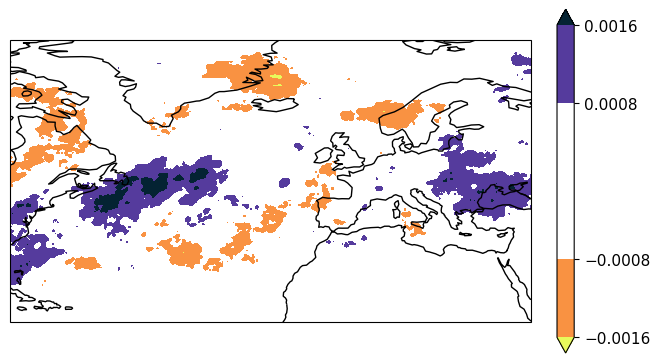

In [29]:
clu = Clusterplot(1, 1, get_region(da_apvs))
_ = clu.add_contourf([compute(da_apvs.mean("time"), progress_bar=True)], cmap=colormaps.thermal_r, transparify=1)

23
24


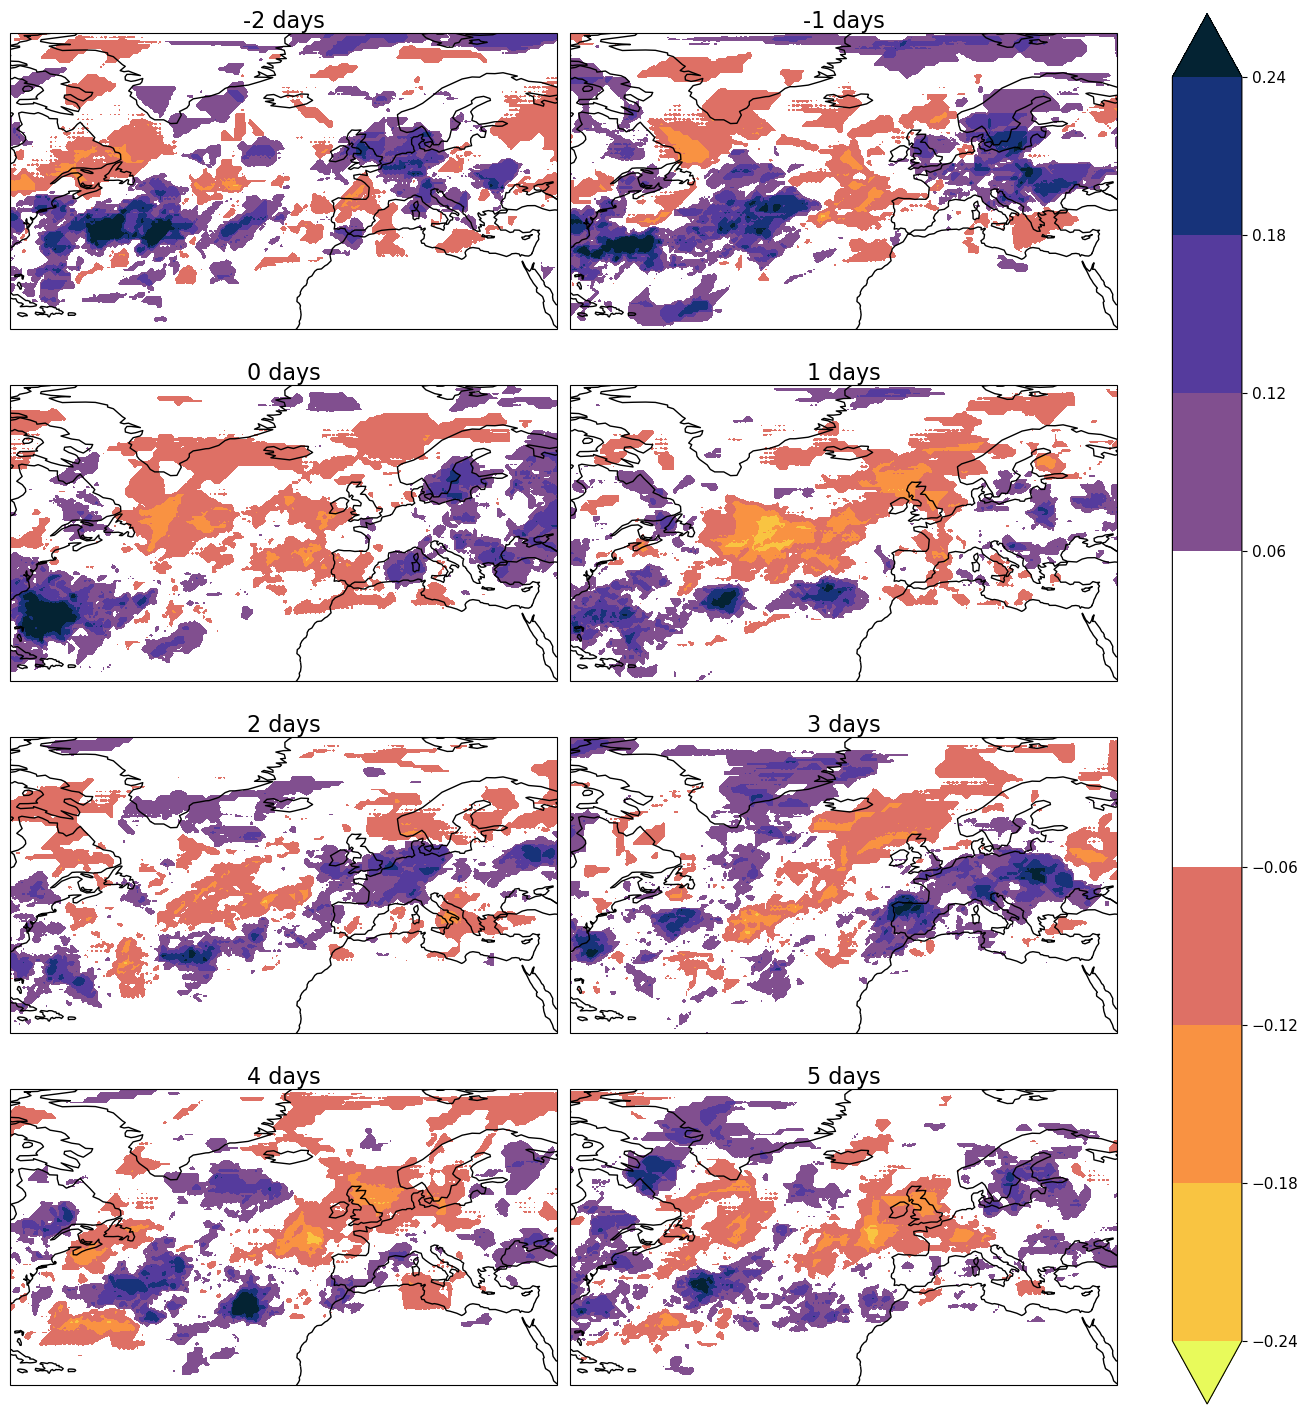

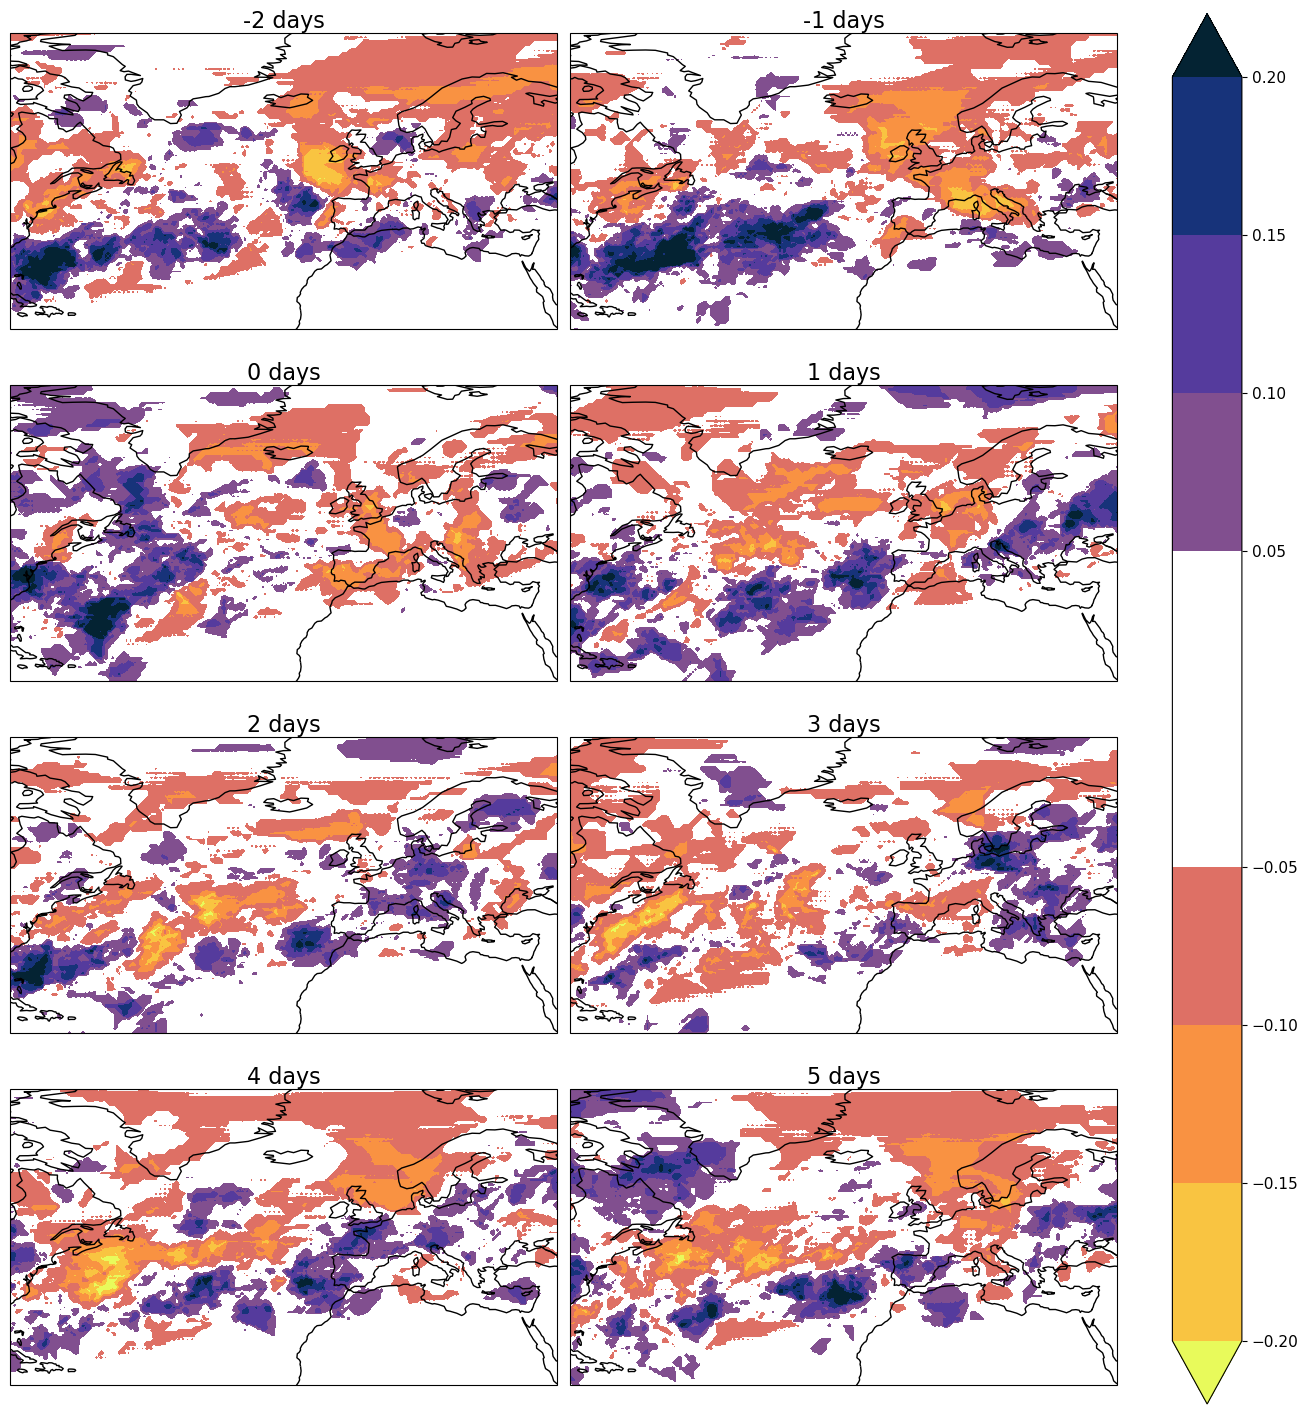

In [30]:
da = da_apvs.copy()
da = compute(da.sel(time=da.time.dt.season == "JJA"))
plot_kwargs = {
    "cmap": colormaps.thermal_r,
    "levels": 7,
    "transparify": 1,
}

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["STJ lifetime"]
to_plot = mask_from_spells_pl(spells_from_jet_daily, da)
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])
_ = clu.add_contourf(
    to_plot,
    titles=to_plot.relative_time.values.astype("timedelta64[D]"),
    **plot_kwargs
)

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["EDJ lifetime"]
to_plot = mask_from_spells_pl(spells_from_jet_daily, da)
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])
_ = clu.add_contourf(
    to_plot,
    titles=to_plot.relative_time.values.astype("timedelta64[D]"),
    **plot_kwargs
)

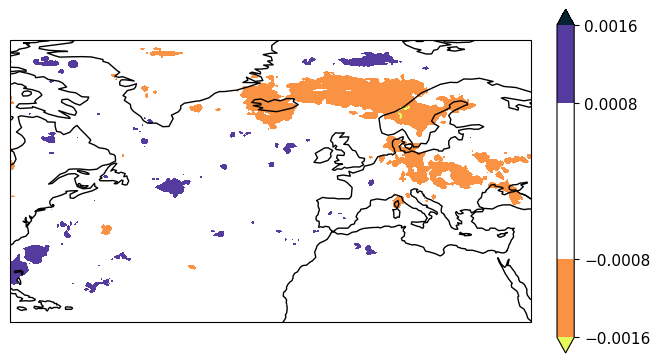

In [31]:
clu = Clusterplot(1, 1, get_region(da_cpvs))
_ = clu.add_contourf([compute(da_cpvs.mean("time"), progress_bar=True)], cmap=colormaps.thermal_r, transparify=1)

23
24


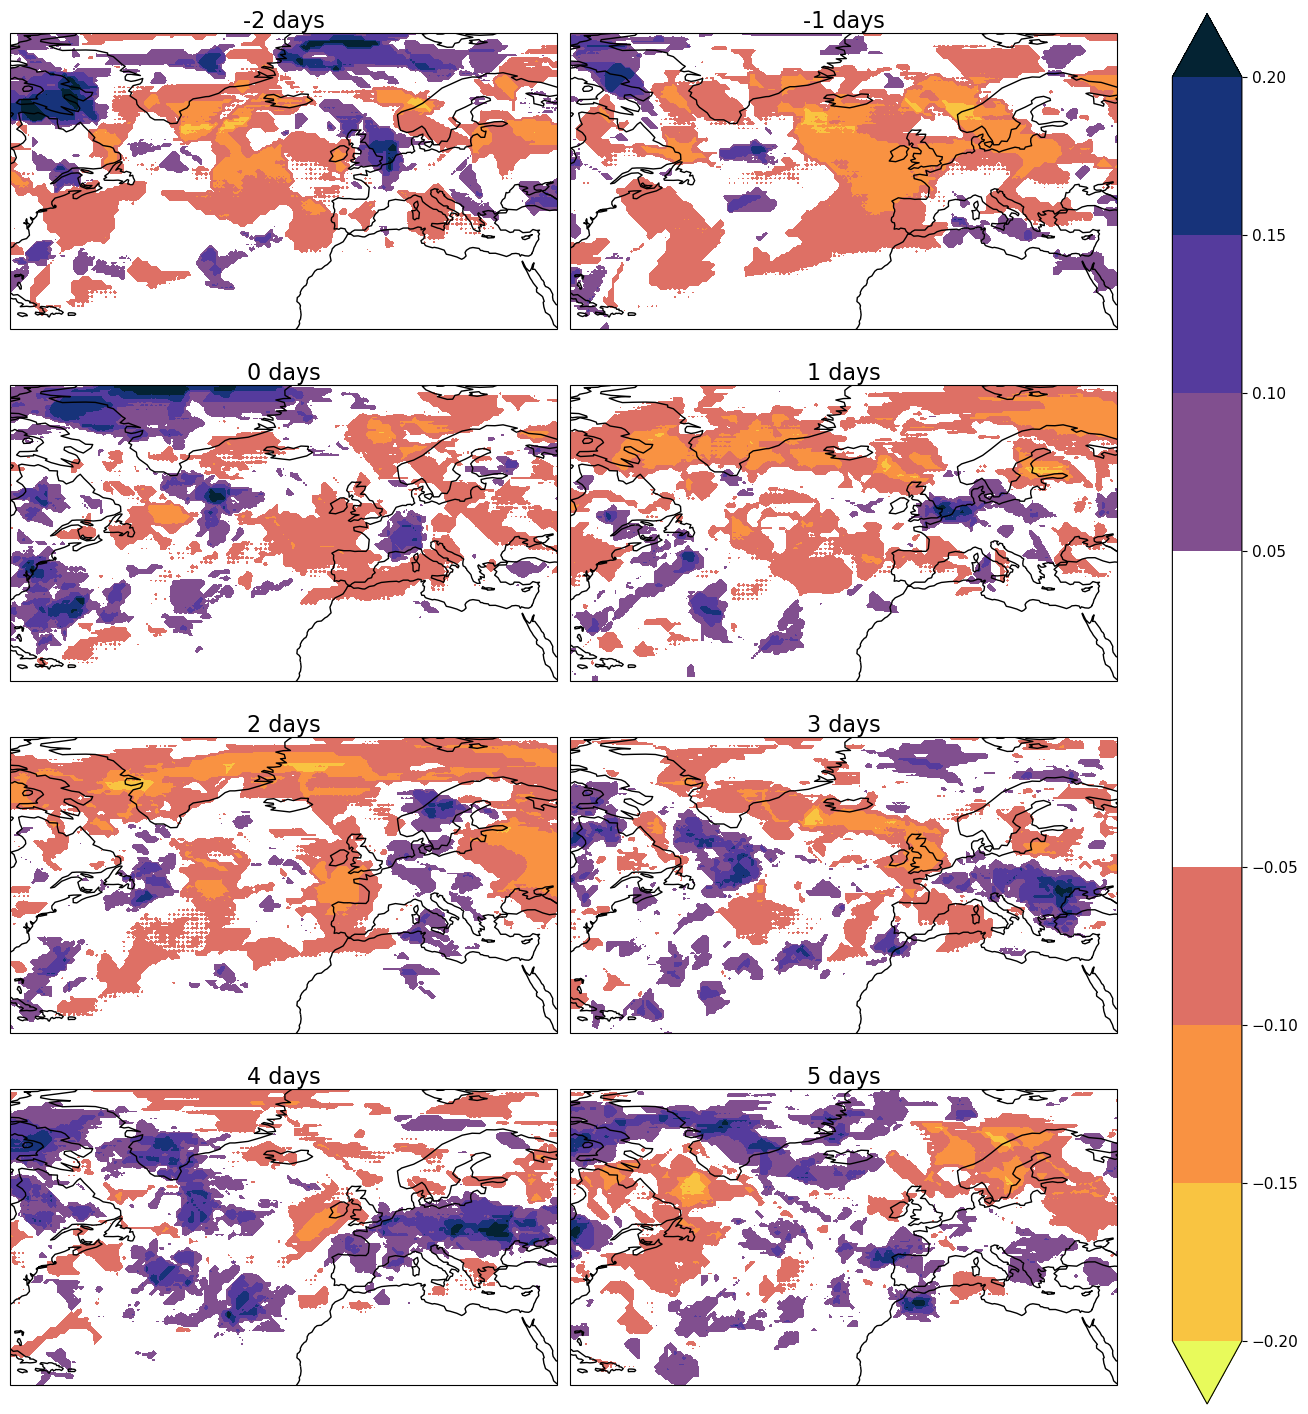

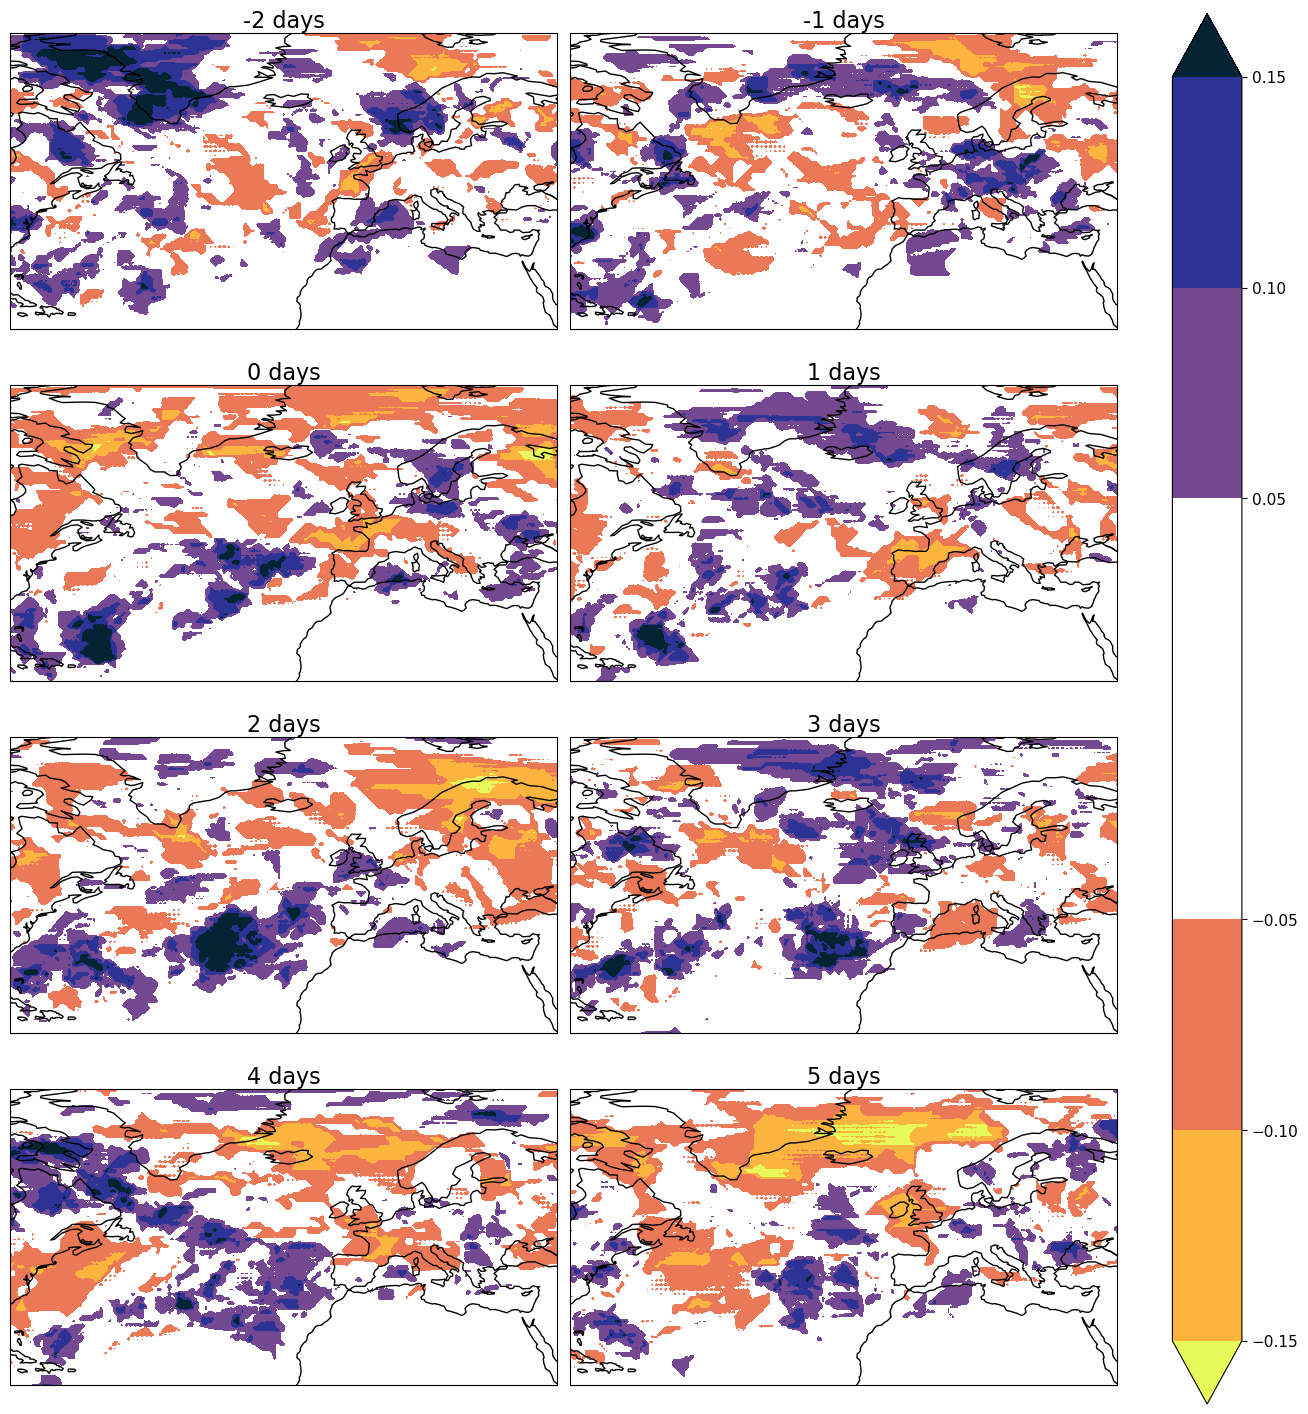

In [32]:
da = da_cpvs.copy()
da = compute(da.sel(time=da.time.dt.season == "JJA"))
plot_kwargs = {
    "cmap": colormaps.thermal_r,
    "levels": 7,
    "transparify": 1,
}

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["STJ lifetime"]
to_plot = mask_from_spells_pl(spells_from_jet_daily, da)
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])
_ = clu.add_contourf(
    to_plot,
    titles=to_plot.relative_time.values.astype("timedelta64[D]"),
    **plot_kwargs
)

clu = Clusterplot(4, 2, get_region(da))
spells_from_jet_daily = spells_list_time_before["EDJ lifetime"]
to_plot = mask_from_spells_pl(spells_from_jet_daily, da)
n_spells = to_plot.spell.shape[0]
print(n_spells)
to_plot = to_plot.mean("spell").sel(relative_index=[-2, -1, 0, 1, 2, 3, 4, 5])
_ = clu.add_contourf(
    to_plot,
    titles=to_plot.relative_time.values.astype("timedelta64[D]"),
    **plot_kwargs
)